In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re, sys
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
sys.path.append('../Andrew')
from utils import evaluate

In [3]:
df = pd.read_csv('../../Data/bird_dataset.csv', index_col=0)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9597 entries, 1 to 9985
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SpecID                         9597 non-null   float64
 1   PassNonPass                    9597 non-null   object 
 2   IOCOrder                       9597 non-null   object 
 3   BLFamilyLatin                  9597 non-null   object 
 4   BLFamilyEnglish                9597 non-null   object 
 5   BLFamSequID                    9597 non-null   float64
 6   Taxo                           9597 non-null   object 
 7   Scientific                     9597 non-null   object 
 8   English                        9597 non-null   object 
 9   Diet-Inv                       9597 non-null   float64
 10  Diet-Vend                      9597 non-null   float64
 11  Diet-Vect                      9597 non-null   float64
 12  Diet-Vfish                     9597 non-null   f

In [124]:
df['migratory'].value_counts()

0.0    7824
1.0    1773
Name: migratory, dtype: int64

In [4]:
# Dropping columns with null values
bird_df = df.drop(columns=['SpecID', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo', 
                      'Scientific', 'English', 'Diet-Source', 'Diet-EnteredBy', 'ForStrat-Source',
                       'ForStrat-EnteredBy', 'BodyMass-Comment', 'BodyMass-Source', 'Record-Comment', 'Unnamed: 0.1', 
                      'English name', 'Family'])

In [5]:
dd_df = bird_df[bird_df['Global IUCN Red List Category'] == 'DD']

In [6]:
dd_df = dd_df.drop(columns=['Global IUCN Red List Category'])

In [7]:
# Dropping DD from bird_df
bird_df = bird_df.drop(index=dd_df.index)

In [8]:
# Creating target column
bird_df['threatened'] = [0.0 if x in ['NT', 'LC'] else 1.0 for x in bird_df['Global IUCN Red List Category']]

In [9]:
X = bird_df.drop(columns=['Global IUCN Red List Category', 'threatened'])
y = bird_df['threatened']

In [10]:
# Creating 10% holdout sets for testing the final model
X_t, X_hold, y_t, y_hold = train_test_split(X,y,random_state=42,stratify=y,test_size=0.1)

In [11]:
# Creating data for training (75% of original)/testing(15% of original)
X_train, X_test, y_train, y_test = train_test_split(X_t,y_t,random_state=42,stratify=y_t,test_size=15/90)

In [12]:
# Setting up some pipelines
# Numeric columns 
num_col = ['BodyMass-Value']
num_pipe = Pipeline([('min_max', MinMaxScaler())])

In [13]:
# Proportional numeric columns
diets = [c for c in X_train.columns if re.search('Diet.+',c)]
strats = [c for c in X_train.columns if re.search('ForStrat.+',c)]

diets = diets[:10]
strats = strats[:7]

prop_cols = strats+diets

prop_pipe = Pipeline([('div100', FunctionTransformer(lambda x: x/100))])

In [129]:
cat_cols

['PassNonPass', 'Diet-5Cat', 'Diet-Certainty']

In [14]:
# Categorical columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype=='object']

cat_pipe = Pipeline([('ohe', OneHotEncoder())])

In [15]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipe, num_col),
    ('proportional', prop_pipe, prop_cols),
    ('categorical', cat_pipe, cat_cols)
],
                                remainder='passthrough')

# Decision Tree Modeling

In [16]:
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('dt', DecisionTreeClassifier())])

dt_grid = {'dt__max_depth': [3,5,50],
          'dt__min_samples_split': [2,5,10],
          'dt__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

dt_gs = GridSearchCV(estimator=dt_pipe, param_grid=dt_grid, scoring=scoring_metrics, refit='recall')

Training Metrics
Accuracy: 0.915
Precision: 0.672
Recall: 0.687
f1: 0.679
----------
Testing Metrics
Accuracy: 0.901
Precision: 0.610
Recall: 0.668
f1: 0.638

Best Parameters
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_split': 5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
13,0.034662,0.001548,0.009081,0.000583,entropy,5,5,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.723404,0.664894,...,0.030628,1,0.674938,0.644330,0.627249,0.636119,0.675676,0.651662,0.020049,1
14,0.034764,0.000638,0.008645,0.000531,entropy,5,10,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.718085,0.664894,...,0.028719,2,0.671642,0.645995,0.625641,0.636119,0.675676,0.651014,0.019619,2
12,0.032737,0.000434,0.008248,0.000672,entropy,5,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.718085,0.664894,...,0.028719,2,0.671642,0.644330,0.627249,0.636119,0.675676,0.651003,0.019313,3
0,0.039156,0.011260,0.011612,0.001996,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.032064,0.004167,0.010937,0.003198,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.059028,0.017673,0.017213,0.004185,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
4,0.073538,0.034725,0.016873,0.004424,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.686170,0.654255,...,0.027988,4,0.649874,0.624365,0.604167,0.625337,0.670185,0.634786,0.022874,7
5,0.044492,0.004835,0.012704,0.003870,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.686170,0.654255,...,0.027988,4,0.649874,0.624365,0.604167,0.625337,0.670185,0.634786,0.022874,7
3,0.086578,0.021600,0.019790,0.003866,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.680851,0.654255,...,0.026744,6,0.648101,0.624365,0.604167,0.625337,0.670185,0.634431,0.022650,9
9,0.027392,0.000622,0.008365,0.000375,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.039156,0.011260,0.011612,0.001996,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.032064,0.004167,0.010937,0.003198,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.059028,0.017673,0.017213,0.004185,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
3,0.086578,0.021600,0.019790,0.003866,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.680851,0.654255,...,0.026744,6,0.648101,0.624365,0.604167,0.625337,0.670185,0.634431,0.022650,9
4,0.073538,0.034725,0.016873,0.004424,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.686170,0.654255,...,0.027988,4,0.649874,0.624365,0.604167,0.625337,0.670185,0.634786,0.022874,7
5,0.044492,0.004835,0.012704,0.003870,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.686170,0.654255,...,0.027988,4,0.649874,0.624365,0.604167,0.625337,0.670185,0.634786,0.022874,7
6,0.048300,0.007300,0.009289,0.001023,gini,50,2,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.617021,0.515957,...,0.038262,14,0.593350,0.521505,0.571429,0.601036,0.584699,0.574404,0.028218,15
7,0.045375,0.003038,0.009038,0.000603,gini,50,5,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.537234,0.505319,...,0.038645,16,0.541555,0.513514,0.582210,0.607330,0.579387,0.564799,0.033152,18
8,0.045180,0.004196,0.008641,0.000690,gini,50,10,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.553191,0.510638,...,0.026709,18,0.550265,0.530387,0.593838,0.592391,0.560000,0.565376,0.024582,17
9,0.027392,0.000622,0.008365,0.000375,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,10


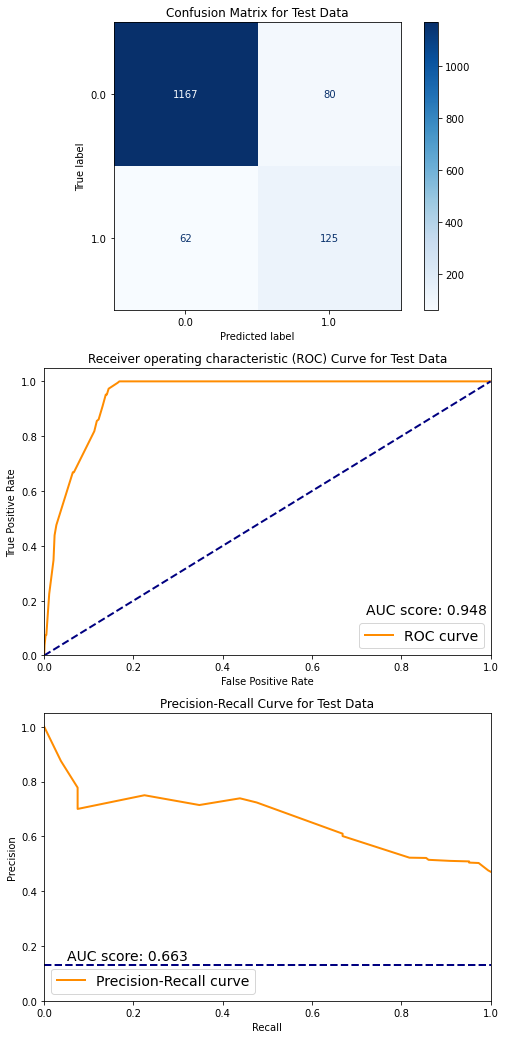

In [17]:
evaluate(dt_gs, X_train, y_train, X_test, y_test, grid_search=True)

In [18]:
dt_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fe549014ca0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [19]:
pd.DataFrame(dt_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.031110,0.003412,0.009990,0.000705,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.027817,0.001106,0.009017,0.001013,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.027821,0.001622,0.009035,0.001653,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
3,0.032584,0.001310,0.008559,0.000665,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.680851,0.659574,...,0.026958,4,0.648101,0.626263,0.604167,0.625337,0.670185,0.634810,0.022494,7
4,0.032836,0.001119,0.008277,0.000657,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.670213,0.654255,...,0.024853,5,0.639594,0.624365,0.607792,0.621622,0.670185,0.632712,0.021285,11
5,0.032502,0.000776,0.008344,0.000412,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.659574,0.654255,...,0.021944,6,0.634271,0.624365,0.607792,0.625337,0.670185,0.632390,0.020742,12
6,0.042749,0.002823,0.008234,0.000502,gini,50,2,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.569149,0.521277,...,0.025020,16,0.563158,0.525469,0.572973,0.592593,0.568306,0.564500,0.021912,18
7,0.051593,0.009381,0.010458,0.001849,gini,50,5,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.542553,0.521277,...,0.031991,15,0.539683,0.528302,0.568306,0.600522,0.590164,0.565395,0.027903,17
8,0.047464,0.002759,0.009846,0.002176,gini,50,10,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.553191,0.542553,...,0.022567,18,0.556150,0.558904,0.589532,0.596774,0.562500,0.572772,0.016918,16
9,0.028566,0.001167,0.009172,0.000978,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,8


AUC Score: 0.7994738173756052


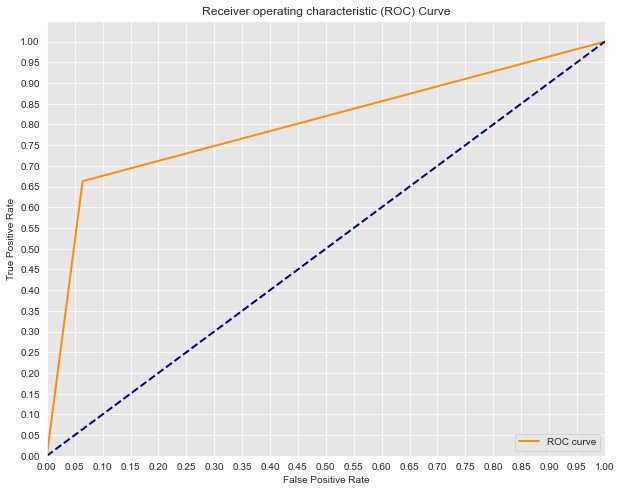

In [20]:
y_score = dt_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [21]:
# Okay scores
print("Train score:",dt_gs.score(X_train,y_train))
print("Test score: ",dt_gs.score(X_test,y_test))

Train score: 0.687299893276414
Test score:  0.6631016042780749


# Logistic Regression Modeling

In [22]:
log_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('log', LogisticRegression())])

log_grid = {'log__class_weight': [None,'balanced'],
          'log__penalty': ['l1', 'l2'],
          'log__C': [.1,.25,.5,1.0],
           'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs = GridSearchCV(estimator=log_pipe, param_grid=log_grid, scoring=scoring_metrics, refit='recall')

In [23]:
log1 = log_gs.fit(X_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

In [24]:
pd.DataFrame(log1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.016128,0.004072,0.000000,0.000000,0.1,None,100,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,0.046817,0.005046,0.009493,0.001464,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.015730,0.002350,0.000000,0.000000,0.1,None,1000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
3,0.051562,0.006268,0.010096,0.002041,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
4,0.014882,0.001332,0.000000,0.000000,0.1,None,10000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
5,0.045634,0.005100,0.008976,0.000617,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
6,0.016662,0.002494,0.000000,0.000000,0.1,balanced,100,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
7,0.056007,0.007153,0.010176,0.002081,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
8,0.017701,0.001956,0.000000,0.000000,0.1,balanced,1000,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
9,0.060348,0.003616,0.011114,0.003046,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10


In [25]:
log1.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.9016205738692649


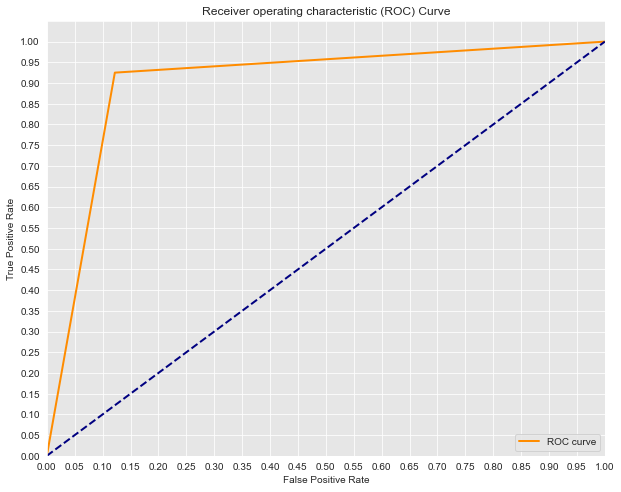

In [26]:
y_score = log1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [27]:
# Good baseline score
print("Train score:",log1.score(X_train,y_train))
print("Test score: ",log1.score(X_test,y_test))

Train score: 0.9327641408751334
Test score:  0.9251336898395722


In [28]:
log_pipe_2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('log', LogisticRegression())])

log_grid_2 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_2 = GridSearchCV(estimator=log_pipe_2, param_grid=log_grid_2, scoring=scoring_metrics, refit='recall')

In [29]:
log2 = log_gs_2.fit(X_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [30]:
pd.DataFrame(log2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.057364,0.006711,0.011371,0.001769,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
1,0.051320,0.003481,0.011075,0.000794,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.053868,0.001816,0.011644,0.001716,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
3,0.064341,0.002566,0.010696,0.001237,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
4,0.065116,0.003877,0.010626,0.000753,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
5,0.062366,0.004504,0.010981,0.000499,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
6,0.070370,0.010623,0.011029,0.002060,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
7,0.078571,0.017091,0.012422,0.002971,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
8,0.077988,0.008241,0.012518,0.002251,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
9,0.080355,0.005194,0.011671,0.001129,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4


In [31]:
log2.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.9016205738692649


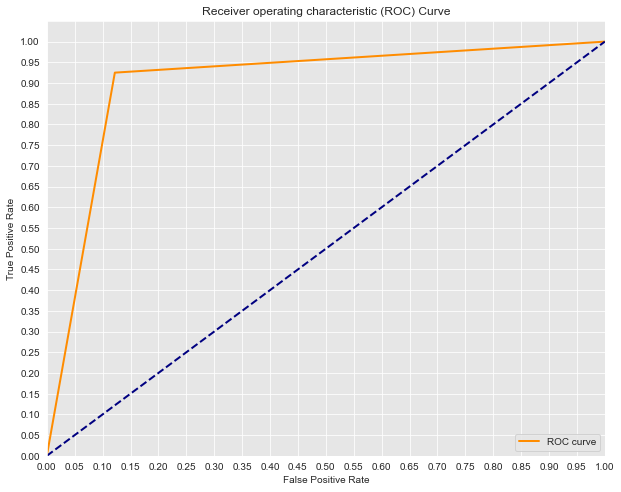

In [32]:
y_score = log2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [33]:
# Same as above
print("Train score:",log2.score(X_train,y_train))
print("Test score: ",log2.score(X_test,y_test))

Train score: 0.9327641408751334
Test score:  0.9251336898395722


In [34]:
data_train = [X_train['agriculture_threat'], X_train['biological_threat'], X_train['climate_change_threat'],
              X_train['energy_mining_threat'], X_train['geological_threat'], X_train['human_intrusions_threat'],
              X_train['natural_systems_threat'], X_train['pollution_threat'], X_train['res_comm_dev_threat'], 
              X_train['transportation_threat'], X_train['invasive_threat']]

threats_train = pd.concat(data_train, axis=1)

In [35]:
data_test = [X_test['agriculture_threat'], X_test['biological_threat'], X_test['climate_change_threat'],
              X_test['energy_mining_threat'], X_test['geological_threat'], X_test['human_intrusions_threat'],
              X_test['natural_systems_threat'], X_test['pollution_threat'], X_test['res_comm_dev_threat'], 
              X_test['transportation_threat'], X_test['invasive_threat']]

threats_test = pd.concat(data_test, axis=1)

In [36]:
log_pipe_3 = Pipeline(steps=[('log', LogisticRegression())])

log_grid_3 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_3 = GridSearchCV(estimator=log_pipe_3, param_grid=log_grid_3, scoring=scoring_metrics, refit='recall')

In [37]:
log3 = log_gs_3.fit(threats_train,y_train)

In [38]:
pd.DataFrame(log3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.031599,0.005091,0.009670,0.002661,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.024736,0.003162,0.007946,0.001324,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.030994,0.013406,0.009569,0.003024,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.022289,0.002010,0.007832,0.001754,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.023255,0.000671,0.008151,0.000753,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.026602,0.006204,0.009090,0.001230,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.025269,0.003477,0.007854,0.001468,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.025076,0.003652,0.007639,0.001077,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.025530,0.001194,0.007969,0.001448,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.025955,0.002054,0.008154,0.000808,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


In [39]:
log3.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.8663273138955954


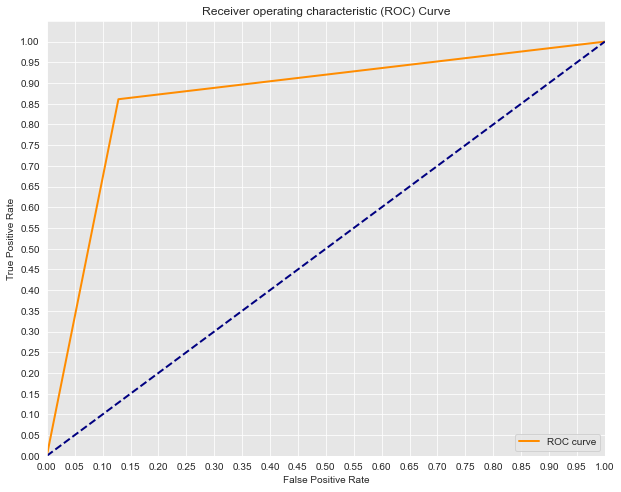

In [40]:
y_score = log3.predict(threats_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [41]:
# Not as good as above, but still pretty good. Slightly overfit.
print("Train score:",log3.score(threats_train,y_train))
print("Test score: ",log3.score(threats_test,y_test))

Train score: 0.9092849519743863
Test score:  0.8609625668449198


In [42]:
log_pipe_4 = Pipeline(steps=[('log', LogisticRegression())])

log_grid_4 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_4 = GridSearchCV(estimator=log_pipe_4, param_grid=log_grid_4, scoring=scoring_metrics, refit='recall')

In [43]:
log4 = log_gs_4.fit(threats_train,y_train)

In [44]:
pd.DataFrame(log4.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.038904,0.006837,0.012786,0.003514,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.025238,0.002542,0.009787,0.001478,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.023622,0.000630,0.008047,0.001247,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.028841,0.004992,0.009754,0.001681,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.030061,0.002099,0.009391,0.001324,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.035320,0.008488,0.010525,0.001869,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.047788,0.028765,0.012036,0.003280,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.040911,0.008167,0.012010,0.001881,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.036864,0.003879,0.011021,0.002353,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.059735,0.045495,0.012148,0.001339,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


In [45]:
# This configuration seems to keep coming up as the best performing set of parameters
log4.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.8663273138955954


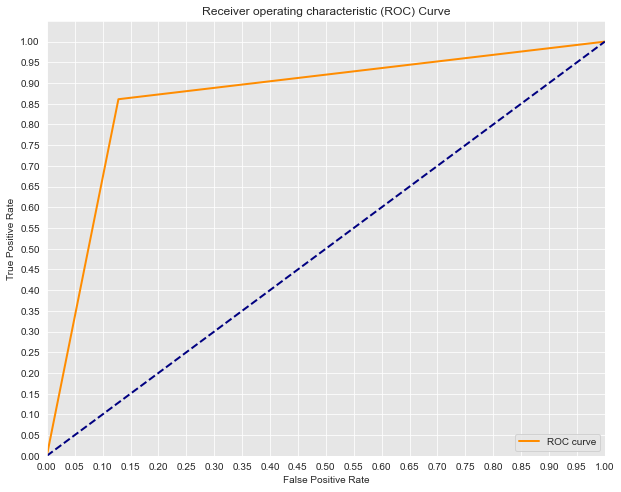

In [46]:
y_score = log4.predict(threats_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [47]:
# Not as good as above, but still pretty good. Slightly overfit.
print("Train score:",log4.score(threats_train,y_train))
print("Test score: ",log4.score(threats_test,y_test))

Train score: 0.9092849519743863
Test score:  0.8609625668449198


# Random Forest Modeling

In [48]:
for_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('for', RandomForestClassifier())])

for_grid1 = {'for__n_estimators': [10,100,1000],
          'for__max_depth': [2,5,10],
          'for__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

for_gs1 = GridSearchCV(estimator=for_pipe1, param_grid=for_grid1, scoring=scoring_metrics, refit='recall')

In [49]:
for1 = for_gs1.fit(X_train,y_train)

In [50]:
pd.DataFrame(for1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__n_estimators,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.069669,0.012141,0.019436,0.001420,gini,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.053191,0.021277,...,0.019727,14,0.100503,0.041451,0.021053,0.000000,0.000000,0.032601,0.037277,14
1,0.362549,0.018252,0.034364,0.001355,gini,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,0.005319,...,0.002611,15,0.010582,0.010582,0.000000,0.000000,0.010638,0.006360,0.005193,15
2,2.372958,0.298071,0.152868,0.022389,gini,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,0.005319,...,0.002611,15,0.010582,0.010582,0.000000,0.000000,0.010638,0.006360,0.005193,15
3,0.049959,0.001685,0.012104,0.001100,gini,5,10,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.430851,0.409574,...,0.044677,7,0.536424,0.506579,0.425373,0.505415,0.469314,0.488621,0.038112,7
4,0.353464,0.035203,0.026668,0.003522,gini,5,100,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.335106,0.404255,...,0.057686,9,0.473684,0.527778,0.446097,0.342857,0.438462,0.445775,0.060248,9
5,3.364269,0.051381,0.171326,0.012097,gini,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.335106,0.340426,...,0.026042,10,0.479087,0.475836,0.448529,0.398438,0.428016,0.445981,0.030256,8
6,0.063974,0.002704,0.012754,0.001085,gini,10,10,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.590426,0.569149,...,0.019478,5,0.623596,0.616715,0.651026,0.631884,0.606607,0.625965,0.015027,5
7,0.439571,0.016537,0.029672,0.001016,gini,10,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.590426,0.606383,...,0.015261,3,0.628895,0.644068,0.652941,0.614035,0.640950,0.636178,0.013486,3
8,3.972484,0.042640,0.188531,0.003801,gini,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.595745,0.585106,...,0.017786,1,0.653061,0.639535,0.664723,0.613569,0.654867,0.645151,0.017714,1
9,0.038025,0.001238,0.010841,0.000430,entropy,2,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.053191,0.111702,...,0.040153,13,0.099010,0.198113,0.031088,0.000000,0.031579,0.071958,0.070888,13


In [51]:
for1.best_params_

{'for__criterion': 'gini', 'for__max_depth': 10, 'for__n_estimators': 1000}

AUC Score: 0.7605654640656291


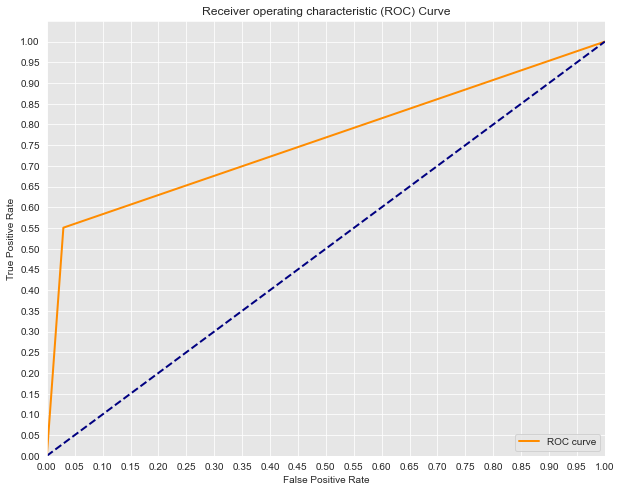

In [52]:
y_score = for1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [53]:
# Overfitting
print("Train score:",for1.score(X_train,y_train))
print("Test score: ",for1.score(X_test,y_test))

Train score: 0.8313767342582711
Test score:  0.5508021390374331


In [54]:
for_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('for', RandomForestClassifier())])

for_grid2 = {'for__n_estimators': [10,100,1000],
             'for__max_depth': [2,5,10,50,100],
             'for__min_samples_split': [2,5,10],
             'for__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

for_gs2 = GridSearchCV(estimator=for_pipe2, param_grid=for_grid2, scoring=scoring_metrics, refit='recall')

In [55]:
for2 = for_gs2.fit(X_train,y_train)

In [56]:
pd.DataFrame(for2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__min_samples_split,param_for__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.054787,0.009013,0.014456,0.002676,gini,2,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,...,0.016914,76,0.010582,0.000000,0.090452,0.031250,0.021053,0.030667,0.031657,76
1,0.257339,0.023915,0.025788,0.001287,gini,2,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.015957,...,0.006211,78,0.031414,0.010582,0.000000,0.000000,0.021053,0.012610,0.012223,78
2,2.428925,0.133589,0.158628,0.013002,gini,2,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,86,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,86
3,0.046943,0.002028,0.013702,0.000894,gini,2,5,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.026596,...,0.020499,75,0.051813,0.109453,0.100503,0.020833,0.021164,0.060753,0.037927,75
4,0.332295,0.040708,0.032021,0.006182,gini,2,5,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.015957,...,0.005827,79,0.031414,0.010582,0.000000,0.000000,0.010638,0.010527,0.011471,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.500552,0.003623,0.030531,0.000536,entropy,100,5,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.654255,...,0.026612,15,0.675824,0.648352,0.686981,0.637681,0.672222,0.664212,0.018291,11
86,5.148082,0.274981,0.228063,0.008762,entropy,100,5,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.654255,...,0.018221,5,0.675824,0.654054,0.675978,0.642254,0.690808,0.667783,0.017333,6
87,0.067038,0.004551,0.011751,0.000901,entropy,100,10,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.611702,...,0.019903,35,0.642458,0.576177,0.596685,0.613699,0.630372,0.611878,0.023605,46
88,0.504748,0.014887,0.030150,0.001222,entropy,100,10,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.675532,...,0.029336,12,0.692098,0.650273,0.681440,0.635838,0.678063,0.667543,0.021025,7


In [57]:
for2.best_params_

{'for__criterion': 'gini',
 'for__max_depth': 50,
 'for__min_samples_split': 5,
 'for__n_estimators': 1000}

AUC Score: 0.7786152005454803


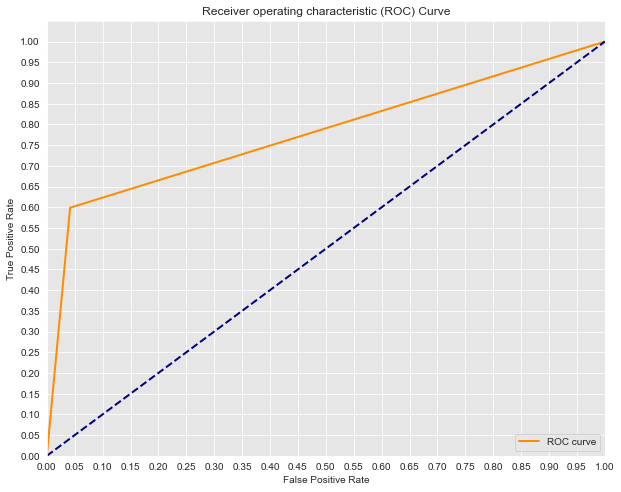

In [58]:
y_score = for2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [59]:
# Massive overfitting
print("Train score:",for2.score(X_train,y_train))
print("Test score: ",for2.score(X_test,y_test))

Train score: 0.991462113127001
Test score:  0.5989304812834224


# Bagged Tree Modeling

In [60]:
bag_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('bag', BaggingClassifier())])

bag_grid1 = {'bag__base_estimator': [DecisionTreeClassifier()],
             'bag__n_estimators': [5,10,15,20],
             'bag__bootstrap': [True,False],
             'bag__bootstrap_features': [True,False]}

scoring_metrics = ['recall', 'f1']

bag_gs1 = GridSearchCV(estimator=bag_pipe1, param_grid=bag_grid1, scoring=scoring_metrics, refit='recall')

In [61]:
bag1 = bag_gs1.fit(X_train,y_train)

In [62]:
pd.DataFrame(bag1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.148409,0.014470,0.013045,0.001085,DecisionTreeClassifier(),True,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.515957,...,0.021703,11,0.552707,0.592798,0.607450,0.596591,0.577259,0.585361,0.018980,9
1,0.282680,0.011480,0.014878,0.000756,DecisionTreeClassifier(),True,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.425532,...,0.028989,16,0.501567,0.526316,0.588235,0.518987,0.525641,0.532149,0.029430,16
2,0.387294,0.013246,0.017193,0.000547,DecisionTreeClassifier(),True,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.643617,...,0.027907,5,0.652291,0.617080,0.631285,0.608187,0.627119,0.627192,0.014901,3
3,0.515786,0.013841,0.020386,0.000613,DecisionTreeClassifier(),True,True,20,{'bag__base_estimator': DecisionTreeClassifier...,0.579787,...,0.030881,12,0.639296,0.563050,0.567976,0.613569,0.603989,0.597576,0.028656,7
4,0.113106,0.008018,0.013950,0.001584,DecisionTreeClassifier(),True,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.622340,...,0.015638,2,0.607792,0.625641,0.617021,0.650667,0.633609,0.626946,0.014657,4
5,0.211653,0.013701,0.013959,0.000734,DecisionTreeClassifier(),True,False,10,{'bag__base_estimator': DecisionTreeClassifier...,0.585106,...,0.007805,8,0.616246,0.590529,0.618497,0.601124,0.631884,0.611656,0.014383,6
6,0.304765,0.010801,0.017001,0.001211,DecisionTreeClassifier(),True,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.617021,...,0.030526,1,0.627027,0.625323,0.666667,0.663158,0.687831,0.654001,0.024244,1
7,0.408611,0.008180,0.020731,0.001235,DecisionTreeClassifier(),True,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.611702,...,0.012268,3,0.623306,0.618667,0.663014,0.644809,0.651811,0.640321,0.016885,2
8,0.232497,0.032262,0.012852,0.001263,DecisionTreeClassifier(),False,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.547872,...,0.026688,13,0.581921,0.575419,0.558140,0.609418,0.563953,0.577770,0.017892,12
9,0.416342,0.043469,0.015755,0.000819,DecisionTreeClassifier(),False,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.585106,...,0.044056,15,0.628571,0.572238,0.529968,0.578947,0.594118,0.580769,0.032000,10


In [63]:
bag1.best_params_

{'bag__base_estimator': DecisionTreeClassifier(),
 'bag__bootstrap': True,
 'bag__bootstrap_features': False,
 'bag__n_estimators': 15}

AUC Score: 0.7413171290240963


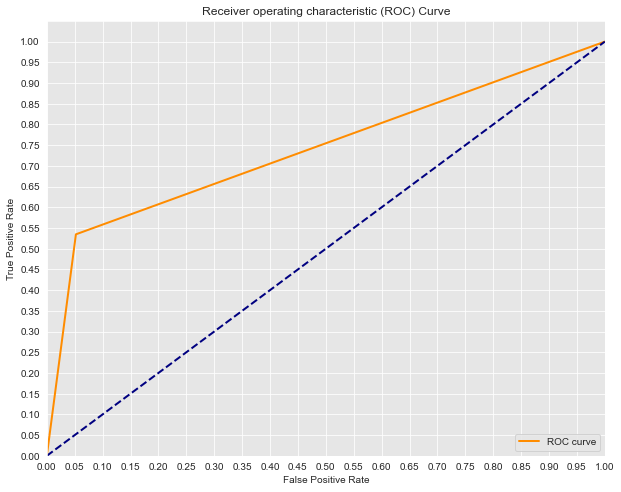

In [64]:
y_score = bag1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [65]:
# Massive overfitting
print("Train score:",bag1.score(X_train,y_train))
print("Test score: ",bag1.score(X_test,y_test))

Train score: 0.9903948772678762
Test score:  0.5347593582887701


In [66]:
bag_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('bag', BaggingClassifier())])

bag_grid2 = {'bag__base_estimator': [DecisionTreeClassifier()],
             'bag__n_estimators': [5,10,15,20],
             'bag__bootstrap': [True,False],
             'bag__bootstrap_features': [True,False],
             'bag__max_samples': [1,5,10],
             'bag__max_features': [1,5,10]}

scoring_metrics = ['recall', 'f1']

bag_gs2 = GridSearchCV(estimator=bag_pipe2, param_grid=bag_grid2, scoring=scoring_metrics, refit='recall')

In [67]:
bag2 = bag_gs2.fit(X_train,y_train)

In [68]:
pd.DataFrame(bag2.cv_results_).sort_values(by='rank_test_recall', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
104,0.027992,0.001018,0.009265,0.000422,DecisionTreeClassifier(),False,True,10,10,5,...,0.121422,1,0.362963,0.000000,0.334545,0.343750,0.000000,0.208252,0.170284,1
68,0.035282,0.007401,0.013451,0.002502,DecisionTreeClassifier(),True,False,10,10,5,...,0.084838,2,0.294964,0.000000,0.010526,0.245763,0.132743,0.136799,0.119637,2
28,0.027285,0.001222,0.010257,0.001369,DecisionTreeClassifier(),True,True,10,5,5,...,0.127576,3,0.000000,0.066351,0.397394,0.000000,0.000000,0.092749,0.154475,3
140,0.029098,0.001522,0.009919,0.000684,DecisionTreeClassifier(),False,False,10,10,5,...,0.073529,4,0.058537,0.041026,0.000000,0.265233,0.020833,0.077126,0.096073,4
32,0.028793,0.001128,0.009969,0.000608,DecisionTreeClassifier(),True,True,10,10,5,...,0.060615,5,0.246809,0.000000,0.000000,0.117073,0.000000,0.072776,0.098121,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.044571,0.001962,0.011544,0.000850,DecisionTreeClassifier(),True,False,1,5,15,...,0.000000,32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32
41,0.034589,0.002591,0.010897,0.000832,DecisionTreeClassifier(),True,False,1,5,10,...,0.000000,32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32
40,0.026099,0.002153,0.010186,0.000942,DecisionTreeClassifier(),True,False,1,5,5,...,0.000000,32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32
78,0.046056,0.002122,0.012233,0.000507,DecisionTreeClassifier(),False,True,1,5,15,...,0.000000,32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32


In [69]:
bag2.best_params_

{'bag__base_estimator': DecisionTreeClassifier(),
 'bag__bootstrap': False,
 'bag__bootstrap_features': True,
 'bag__max_features': 10,
 'bag__max_samples': 10,
 'bag__n_estimators': 5}

AUC Score: 0.5344934795380571


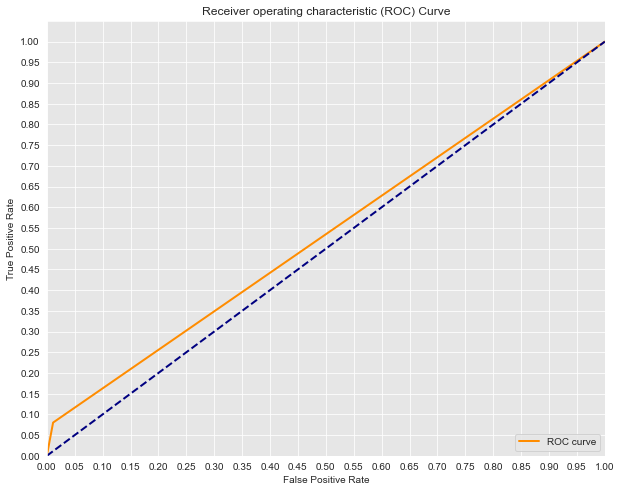

In [70]:
y_score = bag2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [71]:
# 0 doesn't seem good
print("Train score:",bag2.score(X_train,y_train))
print("Test score: ",bag2.score(X_test,y_test))

Train score: 0.10885805763073639
Test score:  0.08021390374331551


# Naive Bayes Modeling

In [72]:
gnb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('gnb', GaussianNB())])

gnb_grid = {'gnb__priors': [None]}

scoring_metrics = ['recall', 'f1']

gnb_gs = GridSearchCV(estimator=gnb_pipe, param_grid=gnb_grid, scoring=scoring_metrics, refit='recall')

In [73]:
gnb_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fe549014ca0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [74]:
pd.DataFrame(gnb_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gnb__priors,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.02575,0.000884,0.010438,0.000606,None,{'gnb__priors': None},0.840426,0.81383,0.705882,0.775401,...,0.069116,1,0.598485,0.616935,0.631579,0.614407,0.589655,0.610212,0.014693,1


AUC Score: 0.803892979514471


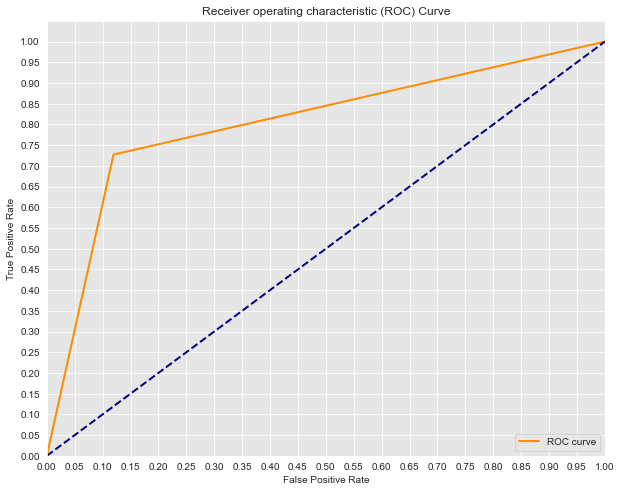

In [75]:
y_score = gnb_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [76]:
# Some overfitting, but not too bad.
print("Train score:",gnb_gs.score(X_train,y_train))
print("Test score: ",gnb_gs.score(X_test,y_test))

Train score: 0.823906083244397
Test score:  0.7272727272727273


In [77]:
mnb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('mnb', MultinomialNB())])

mnb_grid = {'mnb__alpha': [1.0],
           'mnb__fit_prior': [True,False]}

scoring_metrics = ['recall', 'f1']

mnb_gs = GridSearchCV(estimator=mnb_pipe, param_grid=mnb_grid, scoring=scoring_metrics, refit='recall')

In [78]:
mnb_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fe549014ca0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [79]:
pd.DataFrame(mnb_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_mnb__fit_prior,params,split0_test_recall,split1_test_recall,split2_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.019026,0.001600,0.008553,0.000507,1,True,"{'mnb__alpha': 1.0, 'mnb__fit_prior': True}",0.813830,0.760638,0.807487,...,0.020594,2,0.660907,0.655963,0.691076,0.665127,0.656250,0.665865,0.013048,2
1,0.016640,0.000388,0.008120,0.000324,1,False,"{'mnb__alpha': 1.0, 'mnb__fit_prior': False}",0.962766,0.941489,0.957219,...,0.011196,1,0.656987,0.657993,0.675472,0.674374,0.671642,0.667293,0.008107,1


In [80]:
mnb_gs.best_params_

{'mnb__alpha': 1.0, 'mnb__fit_prior': False}

AUC Score: 0.8930674259935075


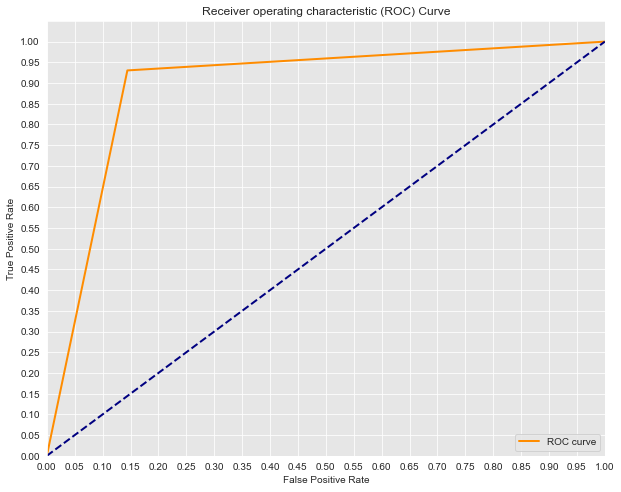

In [81]:
y_score = mnb_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [82]:
# Really good overall.
print("Train score:",mnb_gs.score(X_train,y_train))
print("Test score: ",mnb_gs.score(X_test,y_test))

Train score: 0.951974386339381
Test score:  0.93048128342246


# XGBoost Modeling

In [83]:
xgb_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('xgb', XGBClassifier())])

xgb_grid1 = {'xgb__n_estimators': [10,50,100],
           'xgb__max_depth': [3,5,10],
           'xgb__learning_rate': [0.1,0.2],
           'xgb__min_child_weight': [1,2],
           'xgb__subsample': [0.5,0.7]}

scoring_metrics = ['recall', 'f1']

xgb_gs1 = GridSearchCV(estimator=xgb_pipe1, param_grid=xgb_grid1, scoring=scoring_metrics, refit='recall')

In [84]:
xgb_gs1.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fe549014ca0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [85]:
pd.DataFrame(xgb_gs1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.072660,0.006932,0.014322,0.001512,0.1,3,1,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.023950,1,0.670241,0.681818,0.644330,0.670130,0.692308,0.671765,0.016005,7
1,0.073057,0.003341,0.013604,0.000812,0.1,3,1,10,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.018797,8,0.659740,0.652520,0.630208,0.666667,0.693122,0.660451,0.020416,40
2,0.227852,0.009126,0.016626,0.001378,0.1,3,1,50,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.030093,61,0.671916,0.670241,0.639769,0.657459,0.657382,0.659353,0.011553,46
3,0.255097,0.012478,0.017567,0.000388,0.1,3,1,50,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.025950,47,0.673740,0.671916,0.649860,0.655827,0.649860,0.660241,0.010522,41
4,0.487237,0.011559,0.018630,0.000606,0.1,3,1,100,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.033892,41,0.671835,0.668449,0.645714,0.648045,0.693989,0.665606,0.017644,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.131796,0.020744,0.015025,0.000756,0.2,10,2,10,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.037604,12,0.692708,0.651042,0.691489,0.661376,0.627451,0.664813,0.024848,26
68,0.438689,0.001055,0.015545,0.000695,0.2,10,2,50,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.013687,57,0.648936,0.638961,0.648045,0.670300,0.657459,0.652740,0.010554,62
69,0.490796,0.035195,0.015316,0.000873,0.2,10,2,50,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.014319,54,0.664908,0.650667,0.661202,0.642857,0.645161,0.652959,0.008704,61
70,0.988469,0.136450,0.016630,0.001784,0.2,10,2,100,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.012979,63,0.647368,0.625323,0.646240,0.648199,0.655827,0.644591,0.010207,68


In [86]:
xgb_gs1.best_params_

{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 10,
 'xgb__subsample': 0.5}

AUC Score: 0.7895805548289155


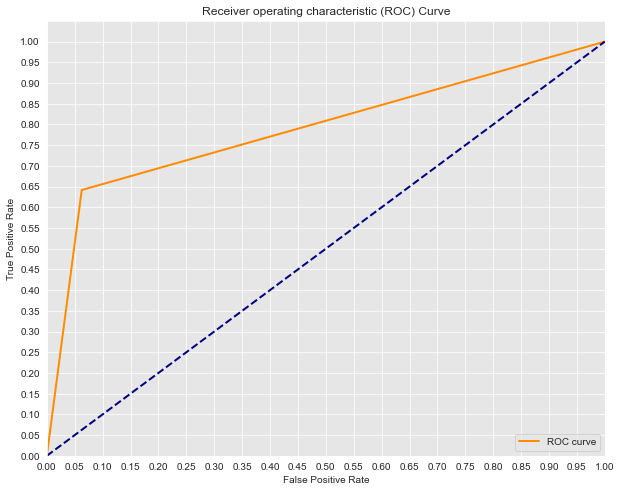

In [87]:
y_score = xgb_gs1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [88]:
# Not as good as MNB but at least not overfit.
print("Train score:",xgb_gs1.score(X_train,y_train))
print("Test score: ",xgb_gs1.score(X_test,y_test))

Train score: 0.6819637139807898
Test score:  0.6417112299465241


In [89]:
xgb_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('xgb', XGBClassifier())])

xgb_grid2 = {'xgb__n_estimators': [1,3,5,10],
           'xgb__max_depth': [1,3,5],
           'xgb__learning_rate': [0.0,0.05,0.1],
           'xgb__min_child_weight': [0,1,2],
           'xgb__subsample': [0.3,0.5,0.7]}

scoring_metrics = ['recall', 'f1']

xgb_gs2 = GridSearchCV(estimator=xgb_pipe2, param_grid=xgb_grid2, scoring=scoring_metrics, refit='recall')

In [90]:
xgb_gs2.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fe549014ca0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [91]:
pd.DataFrame(xgb_gs2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.036987,0.001126,0.013721,0.001044,0,1,0,1,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
1,0.036592,0.000714,0.012939,0.000496,0,1,0,1,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
2,0.035668,0.000416,0.012998,0.000661,0,1,0,1,0.7,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
3,0.037616,0.000157,0.012628,0.000216,0,1,0,3,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
4,0.039495,0.001678,0.012842,0.000686,0,1,0,3,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.059089,0.002531,0.013308,0.000138,0.1,5,2,5,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.033008,96,0.680739,0.652291,0.610644,0.655556,0.662983,0.652443,0.023102,40
320,0.062242,0.006184,0.013578,0.000399,0.1,5,2,5,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.026878,103,0.670213,0.636620,0.627027,0.664879,0.642659,0.648280,0.016588,52
321,0.074493,0.006597,0.013660,0.000654,0.1,5,2,10,0.3,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.025807,77,0.670241,0.632432,0.629834,0.645333,0.690217,0.653612,0.023234,38
322,0.083160,0.003679,0.013308,0.000285,0.1,5,2,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.017919,57,0.663130,0.664894,0.641096,0.682927,0.679245,0.666258,0.014774,9


In [92]:
xgb_gs2.best_params_

{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 1,
 'xgb__min_child_weight': 0,
 'xgb__n_estimators': 1,
 'xgb__subsample': 0.5}

AUC Score: 0.8169939405375038


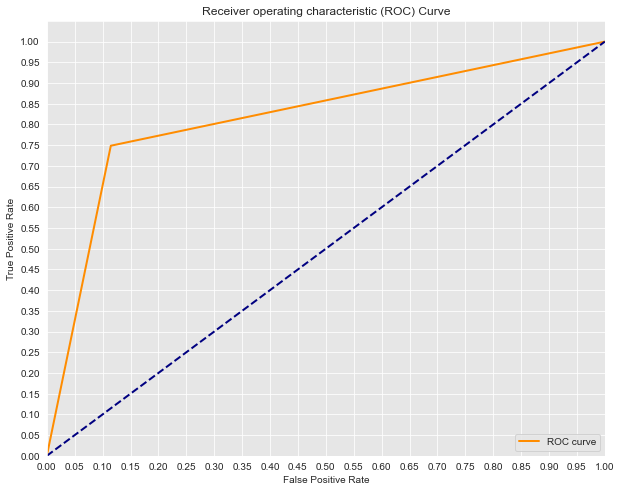

In [93]:
y_score = xgb_gs2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [94]:
# Better than the first one
print("Train score:",xgb_gs2.score(X_train,y_train))
print("Test score: ",xgb_gs2.score(X_test,y_test))

Train score: 0.7801494130202775
Test score:  0.7486631016042781


# Using Andrew's Evaluate Function on all above models

Training Metrics
Accuracy: 0.915
Precision: 0.672
Recall: 0.687
f1: 0.679
----------
Testing Metrics
Accuracy: 0.900
Precision: 0.608
Recall: 0.663
f1: 0.634

Best Parameters
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_split': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
12,0.033303,0.001245,0.008409,0.000625,entropy,5,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.723404,0.664894,...,0.030628,1,0.674938,0.645995,0.627249,0.636119,0.675676,0.651995,0.019938,1
14,0.033439,0.001228,0.008241,0.000371,entropy,5,10,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.718085,0.664894,...,0.028719,2,0.671642,0.645995,0.627249,0.636119,0.675676,0.651336,0.019209,2
13,0.033101,0.000602,0.008789,0.000553,entropy,5,5,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.718085,0.664894,...,0.028719,2,0.671642,0.645995,0.625641,0.636119,0.675676,0.651014,0.019619,3
0,0.033267,0.003701,0.010164,0.001386,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.027574,0.002259,0.008323,0.000170,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.026139,0.000339,0.008357,0.000473,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
4,0.032456,0.001029,0.008107,0.000530,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.680851,0.654255,...,0.028025,5,0.648101,0.624365,0.602597,0.621622,0.670185,0.633374,0.023403,7
9,0.026355,0.001143,0.008231,0.000358,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,8
10,0.026606,0.000902,0.008380,0.000496,entropy,3,5,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,8
11,0.026193,0.001462,0.008472,0.000630,entropy,3,10,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,8


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.033267,0.003701,0.010164,0.001386,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.027574,0.002259,0.008323,0.000170,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.026139,0.000339,0.008357,0.000473,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
3,0.031427,0.000832,0.008435,0.000817,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.670213,0.659574,...,0.025173,4,0.639594,0.626263,0.606218,0.621622,0.670185,0.632776,0.021532,11
4,0.032456,0.001029,0.008107,0.000530,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.680851,0.654255,...,0.028025,5,0.648101,0.624365,0.602597,0.621622,0.670185,0.633374,0.023403,7
5,0.032418,0.001420,0.008463,0.000473,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.659574,0.654255,...,0.024382,6,0.634271,0.624365,0.604167,0.621622,0.670185,0.630922,0.021900,12
6,0.042773,0.002762,0.009361,0.001081,gini,50,2,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.601064,0.558511,...,0.031593,14,0.594737,0.557029,0.594315,0.600000,0.558904,0.580997,0.018920,14
7,0.044891,0.003034,0.009726,0.000695,gini,50,5,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.569149,0.558511,...,0.029409,15,0.563158,0.552632,0.590426,0.601036,0.561798,0.573810,0.018567,17
8,0.042392,0.001750,0.008305,0.000364,gini,50,10,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.547872,0.553191,...,0.023634,17,0.550802,0.560647,0.593220,0.601064,0.568182,0.574783,0.019231,16
9,0.026355,0.001143,0.008231,0.000358,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,8


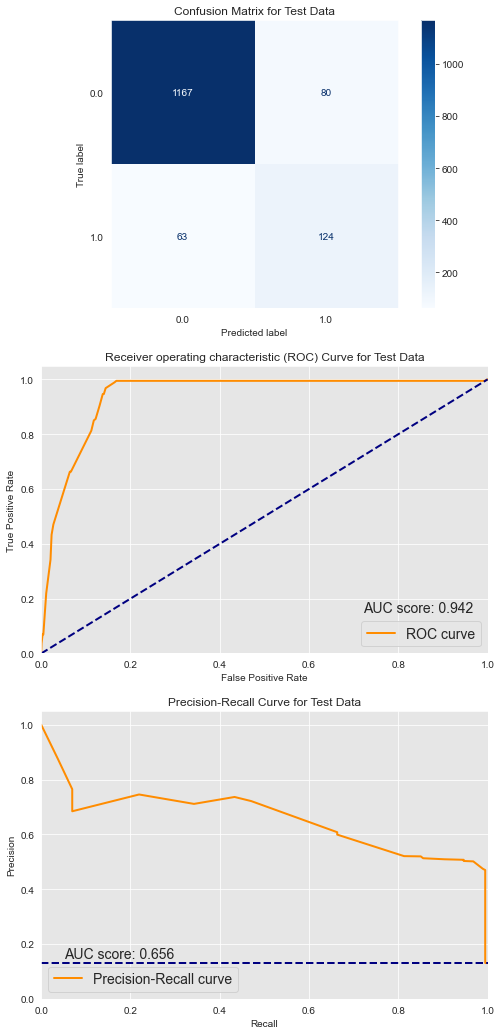

In [95]:
# Decition Tree we worked on together
evaluate(dt_gs, X_train, y_train, X_test, y_test, grid_search=True)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

Training Metrics
Accuracy: 0.893
Precision: 0.555
Recall: 0.933
f1: 0.696
----------
Testing Metrics
Accuracy: 0.884
Precision: 0.532
Recall: 0.925
f1: 0.676

Best Parameters
{'log__C': 0.1, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
47,0.116615,0.013078,0.011468,0.001291,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
45,0.113149,0.003146,0.009865,0.000816,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
43,0.101016,0.008217,0.010223,0.001006,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
21,0.078110,0.003177,0.011279,0.001293,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
19,0.071949,0.004609,0.010998,0.001429,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
23,0.078106,0.005854,0.010120,0.000823,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
31,0.093523,0.006526,0.010947,0.001126,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
33,0.100445,0.013171,0.011801,0.001431,0.5,balanced,1000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
35,0.089257,0.005161,0.011130,0.001619,0.5,balanced,10000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
9,0.056368,0.003957,0.010341,0.002833,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.015067,0.002273,0.000000,0.000000,0.1,None,100,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,0.043829,0.003819,0.009563,0.001380,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.015077,0.000874,0.000000,0.000000,0.1,None,1000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
3,0.043194,0.002665,0.008469,0.000403,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
4,0.014888,0.000815,0.000000,0.000000,0.1,None,10000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
5,0.042479,0.003506,0.008560,0.000305,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
6,0.016005,0.001047,0.000000,0.000000,0.1,balanced,100,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
7,0.052302,0.003704,0.008995,0.001172,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
8,0.016883,0.002669,0.000000,0.000000,0.1,balanced,1000,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
9,0.056368,0.003957,0.010341,0.002833,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10


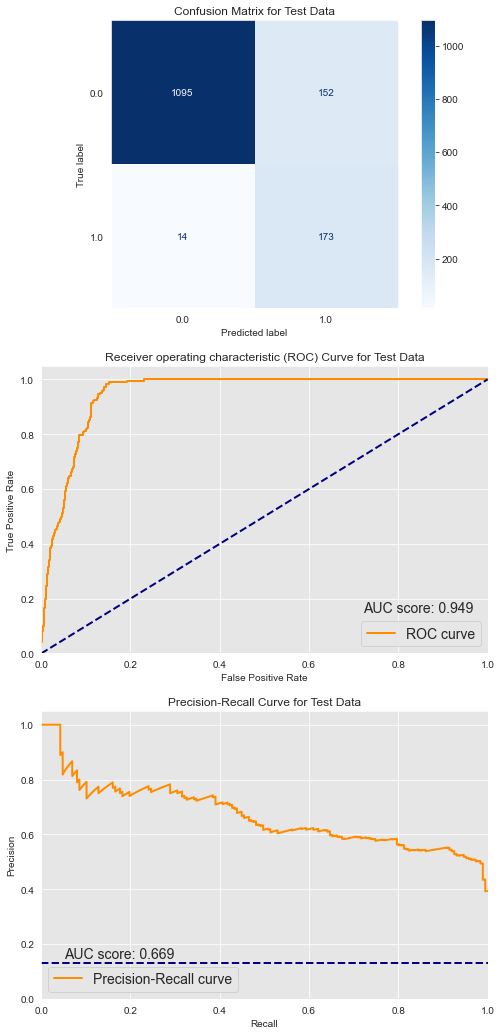

In [96]:
evaluate(log1, X_train, y_train, X_test, y_test, grid_search=True)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Training Metrics
Accuracy: 0.893
Precision: 0.555
Recall: 0.933
f1: 0.696
----------
Testing Metrics
Accuracy: 0.884
Precision: 0.532
Recall: 0.925
f1: 0.676

Best Parameters
{'log__C': 0.1, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
23,0.117173,0.004337,0.010928,0.000640,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
21,0.103608,0.001667,0.011897,0.000694,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
22,0.117011,0.002619,0.009923,0.001009,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
10,0.072966,0.003563,0.010894,0.001340,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
9,0.071698,0.003820,0.010535,0.001453,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
11,0.076648,0.003516,0.010836,0.000813,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
15,0.087830,0.002952,0.010582,0.000901,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
16,0.088142,0.004262,0.011642,0.001309,0.5,balanced,1000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
17,0.089596,0.005856,0.010552,0.001032,0.5,balanced,10000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
4,0.058214,0.002895,0.010231,0.001486,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.052903,0.005976,0.009827,0.000697,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
1,0.050815,0.002691,0.010434,0.000804,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.050066,0.001674,0.010105,0.000934,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
3,0.061414,0.003501,0.011512,0.002098,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
4,0.058214,0.002895,0.010231,0.001486,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
5,0.061184,0.001706,0.009695,0.000878,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
6,0.063942,0.003392,0.011334,0.001456,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
7,0.065269,0.002575,0.009795,0.000719,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
8,0.062751,0.002807,0.009688,0.000955,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
9,0.071698,0.003820,0.010535,0.001453,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4


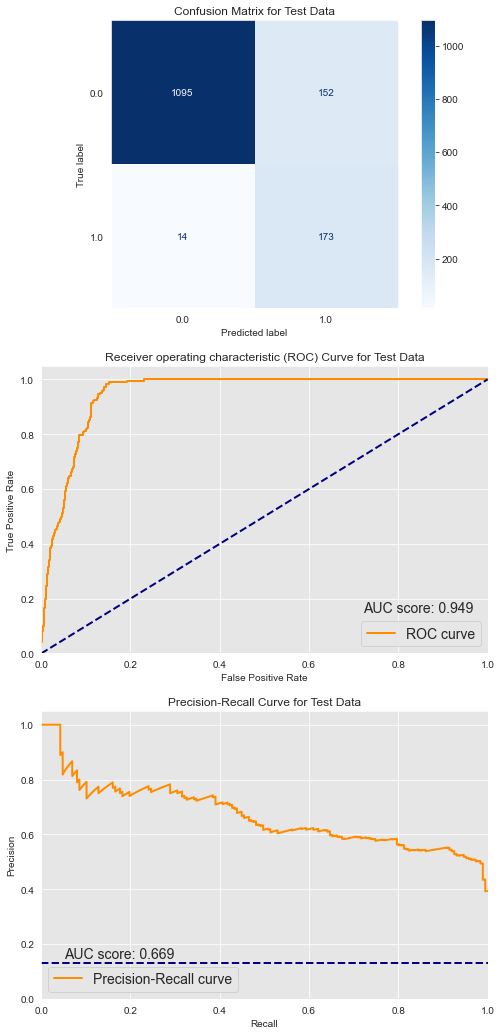

In [97]:
evaluate(log2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.885
Precision: 0.536
Recall: 0.909
f1: 0.674
----------
Testing Metrics
Accuracy: 0.870
Precision: 0.502
Recall: 0.861
f1: 0.634

Best Parameters
{'log__C': 1.0, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
3,0.012991,0.000905,0.004818,0.000800,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.012207,0.000872,0.004448,0.000511,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.013209,0.001733,0.004249,0.000400,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
23,0.018460,0.006344,0.004804,0.000797,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
21,0.013889,0.002039,0.003833,0.000457,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
22,0.014893,0.001475,0.004255,0.000356,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
10,0.013675,0.001791,0.004268,0.000638,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
9,0.013485,0.000985,0.003961,0.000434,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
11,0.013410,0.001552,0.004011,0.000498,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
15,0.013532,0.000900,0.004491,0.000593,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.012505,0.001537,0.004061,0.000336,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.040836,0.051829,0.005592,0.002097,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.014316,0.002306,0.004059,0.000507,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.012991,0.000905,0.004818,0.000800,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.012207,0.000872,0.004448,0.000511,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.013209,0.001733,0.004249,0.000400,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.013285,0.001547,0.004420,0.000329,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.013283,0.000783,0.004399,0.000357,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.014228,0.001669,0.004282,0.000535,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.013485,0.000985,0.003961,0.000434,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


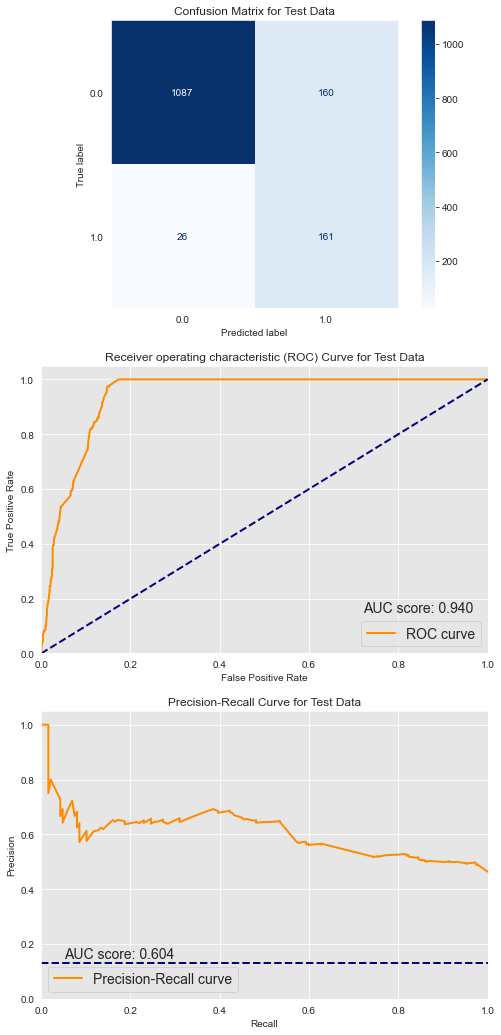

In [98]:
evaluate(log3, threats_train, y_train, threats_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.885
Precision: 0.536
Recall: 0.909
f1: 0.674
----------
Testing Metrics
Accuracy: 0.870
Precision: 0.502
Recall: 0.861
f1: 0.634

Best Parameters
{'log__C': 1.0, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
3,0.013570,0.002136,0.004187,0.000340,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.012894,0.001217,0.004443,0.000413,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.013964,0.002076,0.004173,0.000387,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
23,0.014527,0.000861,0.004450,0.000832,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
21,0.013903,0.000456,0.004378,0.000560,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
22,0.014247,0.001019,0.004475,0.000410,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
10,0.015317,0.001472,0.004088,0.000498,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
9,0.014559,0.002410,0.003939,0.000339,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
11,0.014086,0.001284,0.004057,0.000566,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
15,0.015002,0.001915,0.004352,0.000628,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.012748,0.001331,0.004117,0.000579,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.013098,0.000590,0.004361,0.000466,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.012389,0.001528,0.004361,0.000310,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.013570,0.002136,0.004187,0.000340,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.012894,0.001217,0.004443,0.000413,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.013964,0.002076,0.004173,0.000387,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.013299,0.000858,0.004478,0.000712,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.013405,0.001926,0.004485,0.000544,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.014417,0.003427,0.004816,0.000688,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.014559,0.002410,0.003939,0.000339,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


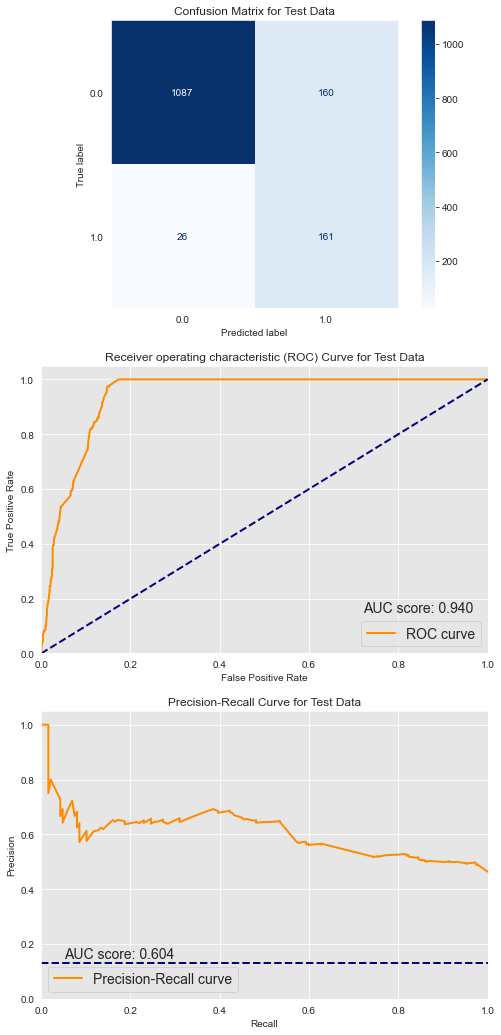

In [99]:
evaluate(log4, threats_train, y_train, threats_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.970
Precision: 0.945
Recall: 0.819
f1: 0.877
----------
Testing Metrics
Accuracy: 0.916
Precision: 0.731
Recall: 0.567
f1: 0.639

Best Parameters
{'for__criterion': 'entropy', 'for__max_depth': 10, 'for__n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__n_estimators,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
17,4.366849,0.233847,0.209736,0.025961,entropy,10,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.574468,0.601064,...,0.019090,1,0.629738,0.643875,0.670520,0.618076,0.648968,0.642235,0.017821,1
8,4.145094,0.010686,0.194214,0.002370,gini,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.590426,0.601064,...,0.011571,3,0.645349,0.645714,0.640950,0.618076,0.644970,0.639012,0.010608,2
7,0.450171,0.004161,0.029161,0.001541,gini,10,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.606383,0.585106,...,0.018125,5,0.657061,0.635838,0.638806,0.614925,0.639296,0.637185,0.013412,3
16,0.437865,0.002751,0.027507,0.000993,entropy,10,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.595745,0.569149,...,0.009378,4,0.630986,0.618497,0.646707,0.629412,0.639296,0.632980,0.009537,4
15,0.060835,0.002130,0.012176,0.001260,entropy,10,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.617021,0.547872,...,0.030900,2,0.633880,0.613095,0.659155,0.616715,0.615836,0.627736,0.017334,5
6,0.063114,0.003573,0.012139,0.001022,gini,10,10,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.643617,0.521277,...,0.044359,6,0.666667,0.579882,0.623229,0.600000,0.619469,0.617849,0.028896,6
12,0.048457,0.001969,0.011711,0.001428,entropy,5,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.452128,0.351064,...,0.042589,7,0.550162,0.464789,0.444444,0.508361,0.492958,0.492143,0.036478,7
13,0.319802,0.001738,0.024201,0.001655,entropy,5,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.351064,0.388298,...,0.043205,8,0.490706,0.515901,0.503546,0.407692,0.431373,0.469844,0.042509,8
4,0.323273,0.007676,0.024710,0.000995,gini,5,100,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.345745,0.356383,...,0.031103,9,0.496183,0.489051,0.475177,0.406130,0.427481,0.458805,0.035597,9
5,3.076403,0.143196,0.168507,0.021158,gini,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.345745,0.340426,...,0.024815,10,0.485075,0.475836,0.431227,0.401544,0.443580,0.447452,0.030354,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__n_estimators,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.042242,0.002163,0.011959,0.000766,gini,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.090426,0.005319,...,0.035184,14,0.161905,0.010582,0.010582,0.000000,0.000000,0.036614,0.062824,14
1,0.229562,0.006717,0.023222,0.002465,gini,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.010638,0.005319,...,0.002119,15,0.021053,0.010582,0.010582,0.010638,0.010638,0.012699,0.004177,15
2,2.235394,0.067314,0.171209,0.035172,gini,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,0.005319,...,0.002613,17,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,17
3,0.047599,0.003311,0.011916,0.000748,gini,5,10,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.377660,0.308511,...,0.040511,12,0.508961,0.428044,0.419847,0.394052,0.375000,0.425181,0.045919,12
4,0.323273,0.007676,0.024710,0.000995,gini,5,100,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.345745,0.356383,...,0.031103,9,0.496183,0.489051,0.475177,0.406130,0.427481,0.458805,0.035597,9
5,3.076403,0.143196,0.168507,0.021158,gini,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.345745,0.340426,...,0.024815,10,0.485075,0.475836,0.431227,0.401544,0.443580,0.447452,0.030354,10
6,0.063114,0.003573,0.012139,0.001022,gini,10,10,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.643617,0.521277,...,0.044359,6,0.666667,0.579882,0.623229,0.600000,0.619469,0.617849,0.028896,6
7,0.450171,0.004161,0.029161,0.001541,gini,10,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.606383,0.585106,...,0.018125,5,0.657061,0.635838,0.638806,0.614925,0.639296,0.637185,0.013412,3
8,4.145094,0.010686,0.194214,0.002370,gini,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.590426,0.601064,...,0.011571,3,0.645349,0.645714,0.640950,0.618076,0.644970,0.639012,0.010608,2
9,0.039894,0.001375,0.011283,0.001037,entropy,2,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.010638,0.000000,...,0.018654,13,0.020942,0.000000,0.098522,0.021164,0.051020,0.038330,0.034206,13


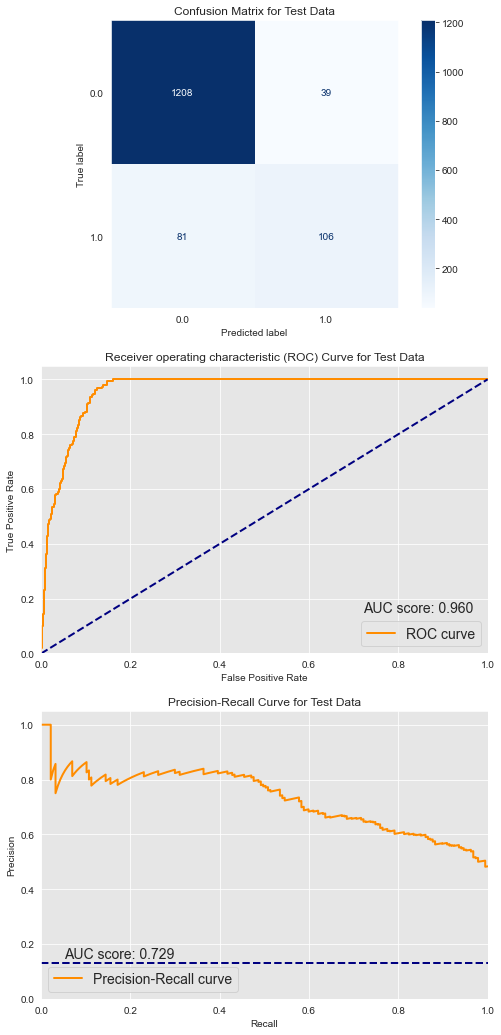

In [100]:
evaluate(for1, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.998
Precision: 0.996
Recall: 0.989
f1: 0.993
----------
Testing Metrics
Accuracy: 0.902
Precision: 0.639
Recall: 0.578
f1: 0.607

Best Parameters
{'for__criterion': 'gini', 'for__max_depth': 100, 'for__min_samples_split': 5, 'for__n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__min_samples_split,param_for__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
40,0.512200,0.022502,0.032408,0.001235,gini,100,5,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.643617,...,0.021388,1,0.666667,0.694960,0.675978,0.661202,0.692098,0.678181,0.013423,1
41,4.892051,0.222709,0.223761,0.005710,gini,100,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.638298,...,0.014031,2,0.661157,0.668464,0.677871,0.662953,0.700000,0.674089,0.014203,2
44,4.574825,0.027189,0.210873,0.002365,gini,100,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.638298,...,0.015257,3,0.661157,0.673913,0.688525,0.662921,0.683616,0.674026,0.010873,3
32,4.765365,0.117631,0.221509,0.004143,gini,50,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.632979,...,0.017344,3,0.661111,0.668449,0.683333,0.657303,0.696379,0.673315,0.014569,4
80,4.633356,0.035390,0.211027,0.003713,entropy,50,10,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.627660,...,0.011038,7,0.657382,0.666667,0.681564,0.666667,0.681690,0.670794,0.009473,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2.163936,0.027346,0.136561,0.004714,gini,2,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,85,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,84
1,0.231471,0.004497,0.024636,0.000916,gini,2,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002620,83,0.000000,0.000000,0.000000,0.010638,0.010582,0.004244,0.005198,84
8,2.146838,0.020458,0.137387,0.002799,gini,2,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,85,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,84
53,2.181269,0.036124,0.136009,0.004456,entropy,2,10,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.000000,...,0.002613,85,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,84


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__min_samples_split,param_for__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.040135,0.002316,0.011173,0.000192,gini,2,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.037234,...,0.029668,76,0.071066,0.010582,0.021164,0.000000,0.144928,0.049548,0.053552,76
1,0.231471,0.004497,0.024636,0.000916,gini,2,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002620,83,0.000000,0.000000,0.000000,0.010638,0.010582,0.004244,0.005198,84
2,2.163936,0.027346,0.136561,0.004714,gini,2,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,85,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,84
3,0.043171,0.004198,0.012850,0.001849,gini,2,5,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,...,0.019566,73,0.010582,0.071795,0.097561,0.109453,0.101010,0.078080,0.036014,73
4,0.240169,0.007190,0.022084,0.000522,gini,2,5,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,...,0.002611,81,0.010582,0.010582,0.000000,0.000000,0.010638,0.006360,0.005193,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.502676,0.005678,0.031337,0.001059,entropy,100,5,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.654255,...,0.033564,20,0.670300,0.643243,0.686813,0.614943,0.653409,0.653742,0.024428,20
86,4.869784,0.047638,0.218328,0.003343,entropy,100,5,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.638298,...,0.014336,12,0.664820,0.652055,0.679775,0.655271,0.687151,0.667814,0.013650,7
87,0.066721,0.002775,0.011657,0.000550,entropy,100,10,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.569149,...,0.026841,36,0.611429,0.646575,0.601719,0.637119,0.609687,0.621306,0.017348,44
88,0.479102,0.004134,0.029847,0.001142,entropy,100,10,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.648936,...,0.010930,16,0.668493,0.650273,0.666667,0.649718,0.680000,0.663030,0.011585,15


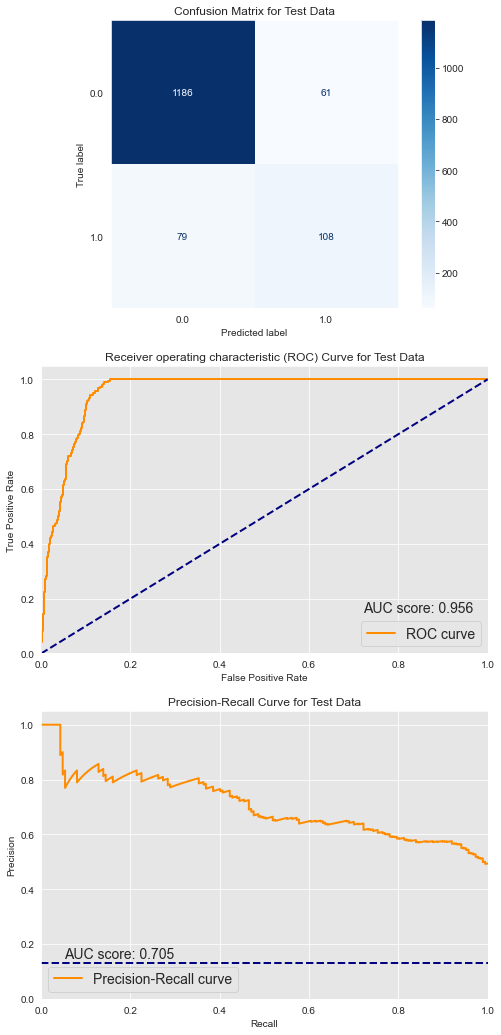

In [101]:
evaluate(for2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.998
Precision: 0.995
Recall: 0.994
f1: 0.994
----------
Testing Metrics
Accuracy: 0.894
Precision: 0.595
Recall: 0.588
f1: 0.591

Best Parameters
{'bag__base_estimator': DecisionTreeClassifier(), 'bag__bootstrap': True, 'bag__bootstrap_features': False, 'bag__n_estimators': 15}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
6,0.296523,0.016222,0.016614,0.001898,DecisionTreeClassifier(),True,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.670213,...,0.023588,1,0.652850,0.608924,0.638070,0.654639,0.664894,0.643875,0.019460,1
7,0.401196,0.025860,0.018536,0.000463,DecisionTreeClassifier(),True,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.627660,...,0.022662,3,0.650138,0.587601,0.619178,0.645333,0.642659,0.628982,0.023283,2
4,0.114600,0.005790,0.011545,0.000165,DecisionTreeClassifier(),True,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.659574,...,0.025634,2,0.649215,0.625323,0.615789,0.632432,0.607242,0.626000,0.014400,3
2,0.393083,0.022619,0.018086,0.001211,DecisionTreeClassifier(),True,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.579787,...,0.034138,8,0.617564,0.621253,0.613636,0.628895,0.575758,0.611421,0.018529,4
11,0.786250,0.025660,0.021278,0.000942,DecisionTreeClassifier(),False,True,20,{'bag__base_estimator': DecisionTreeClassifier...,0.547872,...,0.031655,10,0.604106,0.574780,0.647887,0.600567,0.626437,0.610755,0.024767,5
5,0.209379,0.011544,0.014653,0.000936,DecisionTreeClassifier(),True,False,10,{'bag__base_estimator': DecisionTreeClassifier...,0.585106,...,0.011587,7,0.626781,0.596100,0.611429,0.587571,0.628571,0.610090,0.016277,6
10,0.599182,0.021760,0.019005,0.000819,DecisionTreeClassifier(),False,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.542553,...,0.024322,9,0.605341,0.606557,0.612717,0.594752,0.626039,0.609081,0.010261,7
8,0.215087,0.013910,0.012074,0.000546,DecisionTreeClassifier(),False,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.638298,...,0.041481,12,0.653951,0.569801,0.602899,0.587209,0.579882,0.598748,0.029637,8
3,0.522429,0.012895,0.020889,0.000800,DecisionTreeClassifier(),True,True,20,{'bag__base_estimator': DecisionTreeClassifier...,0.569149,...,0.043854,14,0.618497,0.521472,0.640719,0.590769,0.588589,0.592009,0.040157,9
0,0.142073,0.014839,0.013284,0.001314,DecisionTreeClassifier(),True,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.531915,...,0.038704,13,0.571429,0.596206,0.526012,0.599440,0.609418,0.580501,0.029976,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.142073,0.014839,0.013284,0.001314,DecisionTreeClassifier(),True,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.531915,...,0.038704,13,0.571429,0.596206,0.526012,0.599440,0.609418,0.580501,0.029976,10
1,0.284771,0.024319,0.015295,0.000733,DecisionTreeClassifier(),True,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.521277,...,0.032527,16,0.604938,0.591045,0.555911,0.537975,0.524691,0.562912,0.030625,16
2,0.393083,0.022619,0.018086,0.001211,DecisionTreeClassifier(),True,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.579787,...,0.034138,8,0.617564,0.621253,0.613636,0.628895,0.575758,0.611421,0.018529,4
3,0.522429,0.012895,0.020889,0.000800,DecisionTreeClassifier(),True,True,20,{'bag__base_estimator': DecisionTreeClassifier...,0.569149,...,0.043854,14,0.618497,0.521472,0.640719,0.590769,0.588589,0.592009,0.040157,9
4,0.114600,0.005790,0.011545,0.000165,DecisionTreeClassifier(),True,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.659574,...,0.025634,2,0.649215,0.625323,0.615789,0.632432,0.607242,0.626000,0.014400,3
5,0.209379,0.011544,0.014653,0.000936,DecisionTreeClassifier(),True,False,10,{'bag__base_estimator': DecisionTreeClassifier...,0.585106,...,0.011587,7,0.626781,0.596100,0.611429,0.587571,0.628571,0.610090,0.016277,6
6,0.296523,0.016222,0.016614,0.001898,DecisionTreeClassifier(),True,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.670213,...,0.023588,1,0.652850,0.608924,0.638070,0.654639,0.664894,0.643875,0.019460,1
7,0.401196,0.025860,0.018536,0.000463,DecisionTreeClassifier(),True,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.627660,...,0.022662,3,0.650138,0.587601,0.619178,0.645333,0.642659,0.628982,0.023283,2
8,0.215087,0.013910,0.012074,0.000546,DecisionTreeClassifier(),False,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.638298,...,0.041481,12,0.653951,0.569801,0.602899,0.587209,0.579882,0.598748,0.029637,8
9,0.408562,0.036547,0.015292,0.001353,DecisionTreeClassifier(),False,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.526596,...,0.034943,15,0.584071,0.539589,0.613181,0.539877,0.579882,0.571320,0.028226,14


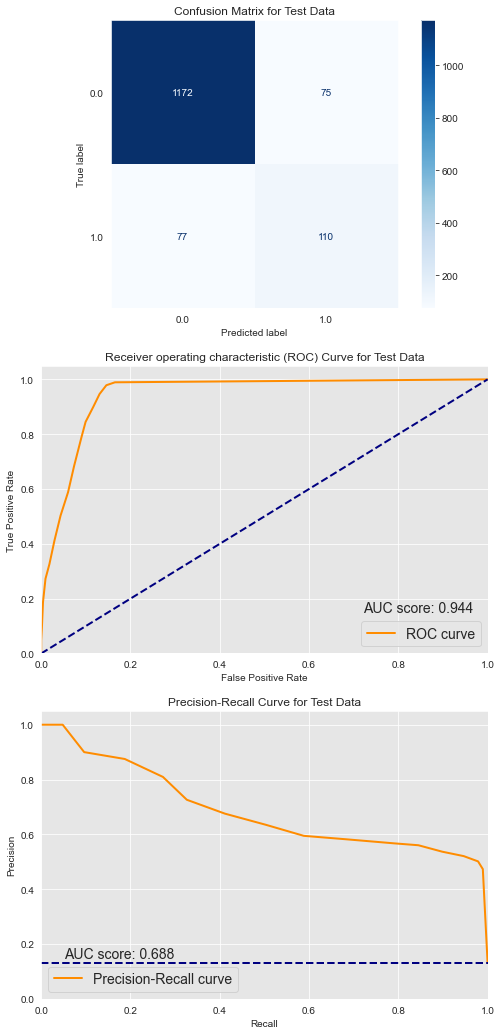

In [102]:
evaluate(bag1, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.836
Precision: 0.410
Recall: 0.572
f1: 0.478
----------
Testing Metrics
Accuracy: 0.819
Precision: 0.360
Recall: 0.503
f1: 0.420

Best Parameters
{'bag__base_estimator': DecisionTreeClassifier(), 'bag__bootstrap': False, 'bag__bootstrap_features': False, 'bag__max_features': 10, 'bag__max_samples': 10, 'bag__n_estimators': 5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
140,0.028246,0.001671,0.009565,0.000600,DecisionTreeClassifier(),False,False,10,10,5,...,0.225939,1,0.563107,0.192982,0.162679,0.028708,0.443787,0.278253,0.195675,1
68,0.027300,0.002145,0.009793,0.000786,DecisionTreeClassifier(),True,False,10,10,5,...,0.072155,3,0.040816,0.000000,0.107843,0.030612,0.300813,0.096017,0.108282,2
32,0.029586,0.002204,0.010680,0.001195,DecisionTreeClassifier(),True,True,10,10,5,...,0.056111,4,0.071795,0.085714,0.232210,0.000000,0.081633,0.094270,0.075700,3
16,0.026533,0.002004,0.010117,0.000690,DecisionTreeClassifier(),True,True,5,5,5,...,0.092962,2,0.277419,0.138728,0.000000,0.000000,0.000000,0.083230,0.110970,4
104,0.027258,0.000653,0.009616,0.000914,DecisionTreeClassifier(),False,True,10,10,5,...,0.032490,6,0.097561,0.000000,0.040816,0.162162,0.064516,0.073011,0.054754,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.042194,0.001623,0.011917,0.000641,DecisionTreeClassifier(),True,False,1,5,15,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
41,0.033993,0.001299,0.011206,0.000874,DecisionTreeClassifier(),True,False,1,5,10,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
40,0.025464,0.000942,0.010298,0.000504,DecisionTreeClassifier(),True,False,1,5,5,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
54,0.044943,0.002268,0.012175,0.000246,DecisionTreeClassifier(),True,False,5,5,15,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.032316,0.004964,0.013150,0.001499,DecisionTreeClassifier(),True,True,1,1,5,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
1,0.034488,0.001396,0.011294,0.000608,DecisionTreeClassifier(),True,True,1,1,10,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
2,0.041031,0.001455,0.012043,0.000597,DecisionTreeClassifier(),True,True,1,1,15,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
3,0.050754,0.002021,0.011916,0.001584,DecisionTreeClassifier(),True,True,1,1,20,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
4,0.025086,0.001129,0.010752,0.000917,DecisionTreeClassifier(),True,True,1,5,5,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.057410,0.001610,0.012230,0.000679,DecisionTreeClassifier(),False,False,10,5,20,...,0.000000,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35
140,0.028246,0.001671,0.009565,0.000600,DecisionTreeClassifier(),False,False,10,10,5,...,0.225939,1,0.563107,0.192982,0.162679,0.028708,0.443787,0.278253,0.195675,1
141,0.037758,0.001855,0.011421,0.001424,DecisionTreeClassifier(),False,False,10,10,10,...,0.004275,24,0.000000,0.010582,0.000000,0.021164,0.000000,0.006349,0.008466,22
142,0.048149,0.002403,0.011893,0.000867,DecisionTreeClassifier(),False,False,10,10,15,...,0.008284,18,0.000000,0.000000,0.010638,0.040404,0.000000,0.010208,0.015650,19


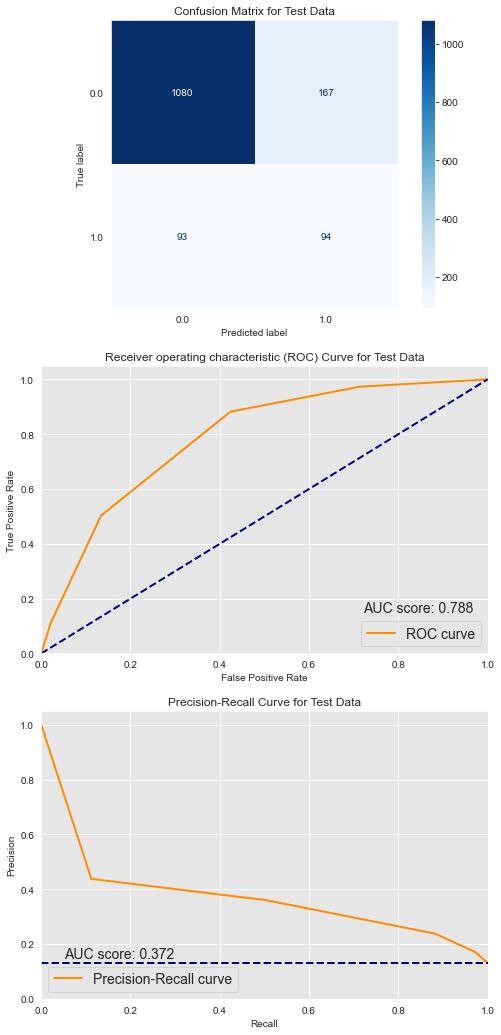

In [103]:
evaluate(bag2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.868
Precision: 0.498
Recall: 0.824
f1: 0.621
----------
Testing Metrics
Accuracy: 0.861
Precision: 0.477
Recall: 0.727
f1: 0.576

Best Parameters
{'gnb__priors': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gnb__priors,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.029328,0.003515,0.01277,0.00118,None,{'gnb__priors': None},0.840426,0.81383,0.705882,0.775401,...,0.069116,1,0.598485,0.616935,0.631579,0.614407,0.589655,0.610212,0.014693,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gnb__priors,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.029328,0.003515,0.01277,0.00118,None,{'gnb__priors': None},0.840426,0.81383,0.705882,0.775401,...,0.069116,1,0.598485,0.616935,0.631579,0.614407,0.589655,0.610212,0.014693,1


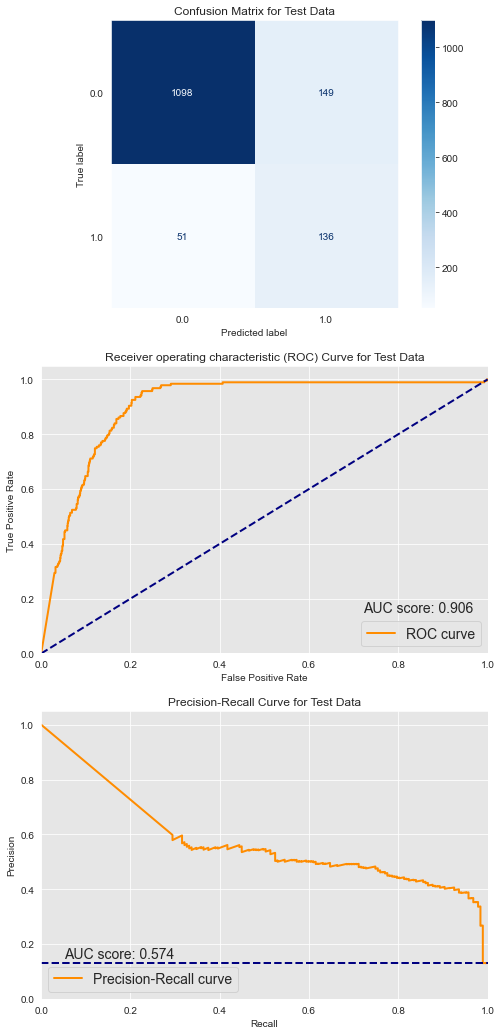

In [104]:
evaluate(gnb_gs, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.877
Precision: 0.516
Recall: 0.952
f1: 0.669
----------
Testing Metrics
Accuracy: 0.865
Precision: 0.492
Recall: 0.930
f1: 0.643

Best Parameters
{'mnb__alpha': 1.0, 'mnb__fit_prior': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_mnb__fit_prior,params,split0_test_recall,split1_test_recall,split2_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
1,0.019813,0.001628,0.008255,0.000569,1,False,"{'mnb__alpha': 1.0, 'mnb__fit_prior': False}",0.962766,0.941489,0.957219,...,0.011196,1,0.656987,0.657993,0.675472,0.674374,0.671642,0.667293,0.008107,1
0,0.020171,0.002711,0.011200,0.002225,1,True,"{'mnb__alpha': 1.0, 'mnb__fit_prior': True}",0.813830,0.760638,0.807487,...,0.020594,2,0.660907,0.655963,0.691076,0.665127,0.656250,0.665865,0.013048,2


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_mnb__fit_prior,params,split0_test_recall,split1_test_recall,split2_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.020171,0.002711,0.011200,0.002225,1,True,"{'mnb__alpha': 1.0, 'mnb__fit_prior': True}",0.813830,0.760638,0.807487,...,0.020594,2,0.660907,0.655963,0.691076,0.665127,0.656250,0.665865,0.013048,2
1,0.019813,0.001628,0.008255,0.000569,1,False,"{'mnb__alpha': 1.0, 'mnb__fit_prior': False}",0.962766,0.941489,0.957219,...,0.011196,1,0.656987,0.657993,0.675472,0.674374,0.671642,0.667293,0.008107,1


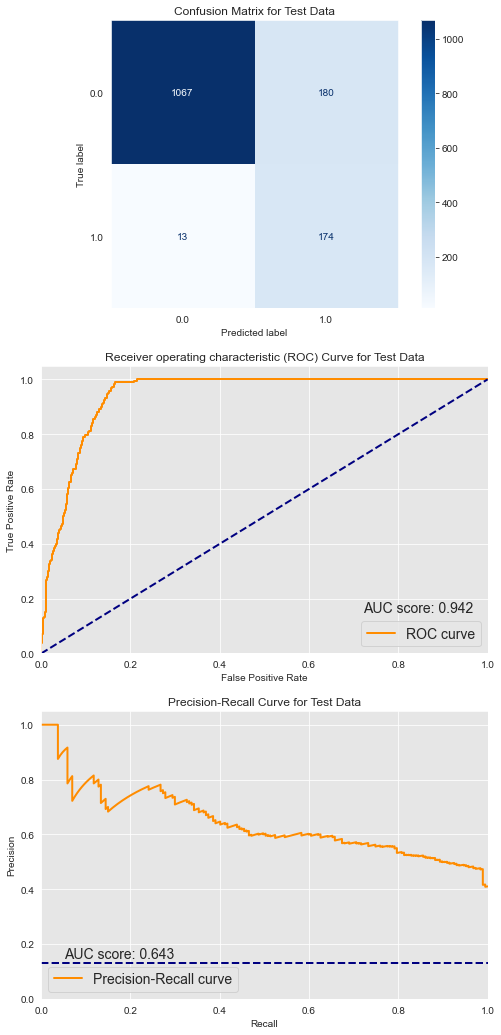

In [105]:
evaluate(mnb_gs, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.913
Precision: 0.660
Recall: 0.682
f1: 0.671
----------
Testing Metrics
Accuracy: 0.899
Precision: 0.606
Recall: 0.642
f1: 0.623

Best Parameters
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 10, 'xgb__subsample': 0.5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
36,0.073750,0.002625,0.014520,0.000872,0.2,3,1,10,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.037704,3,0.652632,0.686131,0.653951,0.686170,0.704000,0.676577,0.020103,1
42,0.071489,0.002756,0.013821,0.000372,0.2,3,2,10,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.033307,4,0.654354,0.679803,0.653951,0.693122,0.700265,0.676299,0.019239,2
49,0.090950,0.002985,0.013989,0.000317,0.2,5,1,10,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.011728,6,0.693767,0.658031,0.654054,0.670241,0.694215,0.674062,0.017125,3
47,0.386292,0.005119,0.015834,0.000179,0.2,3,2,100,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.019056,27,0.682415,0.657682,0.674221,0.677596,0.677871,0.673957,0.008544,4
38,0.210210,0.002313,0.015157,0.000489,0.2,3,1,50,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.030954,22,0.683938,0.677333,0.647727,0.663014,0.694444,0.673291,0.016348,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.072580,0.062141,0.016799,0.001232,0.2,10,2,100,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.012979,63,0.647368,0.625323,0.646240,0.648199,0.655827,0.644591,0.010207,68
62,0.503196,0.040902,0.015186,0.000351,0.2,10,1,50,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.026947,69,0.640000,0.609626,0.675603,0.632768,0.659341,0.643468,0.022612,69
65,1.032619,0.035067,0.016646,0.000921,0.2,10,1,100,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.026065,72,0.648936,0.646739,0.642659,0.603352,0.663014,0.640940,0.020003,70
63,0.503374,0.012777,0.015350,0.001094,0.2,10,1,50,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.030071,70,0.643617,0.654255,0.628415,0.605042,0.666667,0.639599,0.021368,71


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.072968,0.006057,0.013776,0.000896,0.1,3,1,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.023950,1,0.670241,0.681818,0.644330,0.670130,0.692308,0.671765,0.016005,7
1,0.068220,0.003232,0.014670,0.001823,0.1,3,1,10,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.018797,8,0.659740,0.652520,0.630208,0.666667,0.693122,0.660451,0.020416,40
2,0.210744,0.004762,0.015289,0.001628,0.1,3,1,50,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.030093,61,0.671916,0.670241,0.639769,0.657459,0.657382,0.659353,0.011553,46
3,0.245661,0.010306,0.016019,0.001155,0.1,3,1,50,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.025950,47,0.673740,0.671916,0.649860,0.655827,0.649860,0.660241,0.010522,41
4,0.437547,0.026673,0.017350,0.001284,0.1,3,1,100,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.033892,41,0.671835,0.668449,0.645714,0.648045,0.693989,0.665606,0.017644,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.128216,0.011738,0.015436,0.001116,0.2,10,2,10,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.037604,12,0.692708,0.651042,0.691489,0.661376,0.627451,0.664813,0.024848,26
68,0.661700,0.148425,0.018230,0.001641,0.2,10,2,50,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.013687,57,0.648936,0.638961,0.648045,0.670300,0.657459,0.652740,0.010554,62
69,0.718429,0.113247,0.018147,0.001399,0.2,10,2,50,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.014319,54,0.664908,0.650667,0.661202,0.642857,0.645161,0.652959,0.008704,61
70,1.072580,0.062141,0.016799,0.001232,0.2,10,2,100,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.012979,63,0.647368,0.625323,0.646240,0.648199,0.655827,0.644591,0.010207,68


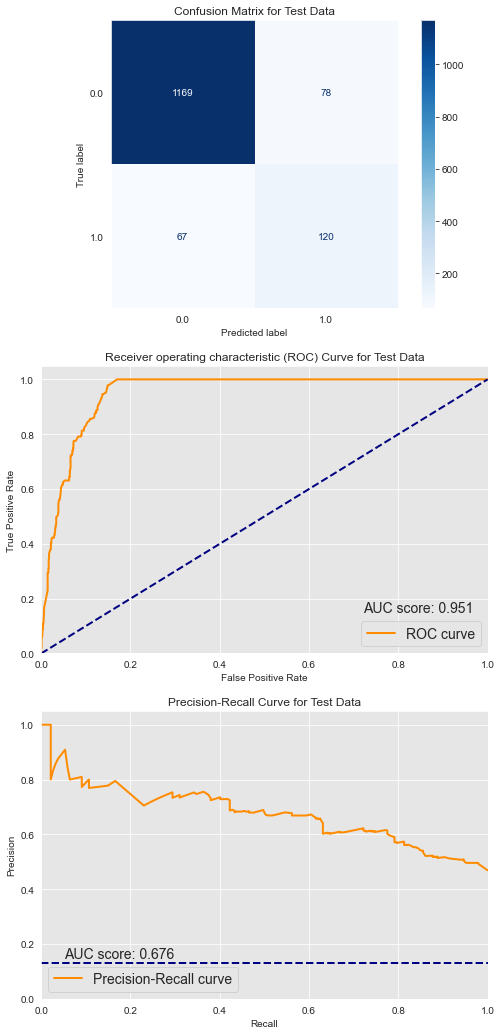

In [106]:
evaluate(xgb_gs1, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.880
Precision: 0.529
Recall: 0.780
f1: 0.630
----------
Testing Metrics
Accuracy: 0.868
Precision: 0.495
Recall: 0.749
f1: 0.596

Best Parameters
{'xgb__learning_rate': 0.05, 'xgb__max_depth': 1, 'xgb__min_child_weight': 0, 'xgb__n_estimators': 1, 'xgb__subsample': 0.5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
262,0.068256,0.002397,0.013467,0.000519,0.1,3,0,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.023950,31,0.670241,0.681818,0.644330,0.670130,0.692308,0.671765,0.016005,1
274,0.068776,0.003278,0.013263,0.000335,0.1,3,1,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.023950,31,0.670241,0.681818,0.644330,0.670130,0.692308,0.671765,0.016005,1
286,0.066621,0.002507,0.013334,0.000506,0.1,3,2,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.027596,33,0.663073,0.681818,0.640827,0.670130,0.692308,0.669631,0.017525,3
189,0.075093,0.003490,0.014189,0.000689,0.05,5,0,10,0.3,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",...,0.026960,40,0.677165,0.671958,0.634409,0.652520,0.711230,0.669456,0.025791,4
166,0.066951,0.002388,0.013897,0.001324,0.05,3,1,10,0.5,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",...,0.031465,34,0.676923,0.671795,0.619048,0.671916,0.697917,0.667520,0.026075,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.061980,0.002768,0.013176,0.000283,0,3,2,10,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
70,0.066868,0.001713,0.013215,0.000397,0,3,2,10,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
71,0.069266,0.002499,0.013448,0.000409,0,3,2,10,0.7,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
57,0.061956,0.001938,0.013650,0.000331,0,3,1,10,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.036355,0.001665,0.013382,0.000734,0,1,0,1,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
1,0.036460,0.000860,0.013243,0.000553,0,1,0,1,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
2,0.036340,0.000923,0.012987,0.000339,0,1,0,1,0.7,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
3,0.038800,0.001131,0.013766,0.000854,0,1,0,3,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
4,0.038309,0.001266,0.013154,0.000726,0,1,0,3,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.060940,0.001477,0.013951,0.000846,0.1,5,2,5,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.033008,96,0.680739,0.652291,0.610644,0.655556,0.662983,0.652443,0.023102,40
320,0.062186,0.002768,0.014126,0.000869,0.1,5,2,5,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.026878,103,0.670213,0.636620,0.627027,0.664879,0.642659,0.648280,0.016588,52
321,0.074922,0.001903,0.013777,0.000443,0.1,5,2,10,0.3,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.025807,77,0.670241,0.632432,0.629834,0.645333,0.690217,0.653612,0.023234,38
322,0.086309,0.002614,0.013608,0.000490,0.1,5,2,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.017919,57,0.663130,0.664894,0.641096,0.682927,0.679245,0.666258,0.014774,9


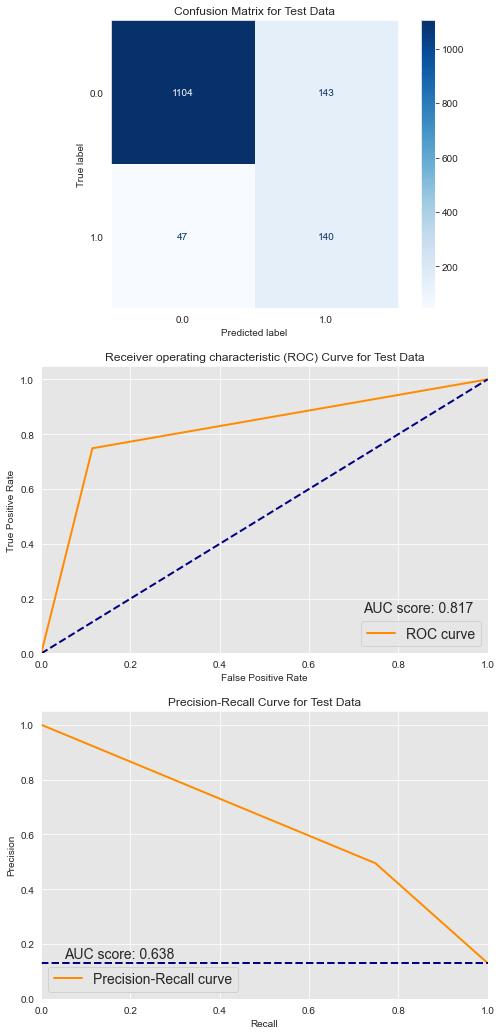

In [107]:
evaluate(xgb_gs2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Accuracy: 0.885
Precision: 0.536
Recall: 0.909
f1: 0.674
----------
Testing Metrics
Accuracy: 0.870
Precision: 0.502
Recall: 0.861
f1: 0.634

Best Parameters
{'log__C': 1.0, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
3,0.011868,0.000527,0.004046,0.000264,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.011860,0.000441,0.004104,0.000210,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.011512,0.000546,0.003731,0.000102,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
23,0.013207,0.001398,0.003994,0.000654,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
21,0.013211,0.000704,0.003789,0.000162,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
22,0.012671,0.000540,0.003852,0.000241,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
10,0.011919,0.000360,0.003684,0.000128,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
9,0.012721,0.000538,0.004000,0.000389,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
11,0.012543,0.000806,0.003938,0.000510,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
15,0.012473,0.001011,0.003686,0.000096,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10


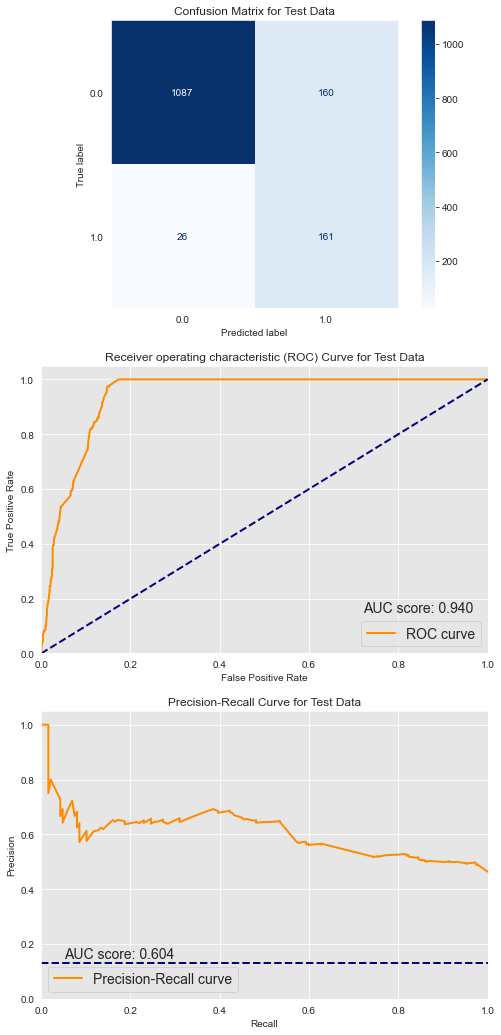

In [108]:
log3_eval = evaluate(log3, threats_train, y_train, threats_test, y_test, grid_search=True)

In [109]:
log3.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

In [110]:
log3_best = Pipeline(steps=[('log', LogisticRegression(C=1.0, 
                                                       class_weight='balanced',
                                                       max_iter= 100,
                                                       penalty= 'l2'))])

In [111]:
log3_best.fit(threats_train, y_train)

Pipeline(steps=[('log', LogisticRegression(class_weight='balanced'))])

In [112]:
threats_train.columns

Index(['agriculture_threat', 'biological_threat', 'climate_change_threat',
       'energy_mining_threat', 'geological_threat', 'human_intrusions_threat',
       'natural_systems_threat', 'pollution_threat', 'res_comm_dev_threat',
       'transportation_threat', 'invasive_threat'],
      dtype='object')

Feature: 0, Score: 2.86876
Feature: 1, Score: 1.58181
Feature: 2, Score: 1.16902
Feature: 3, Score: 0.23005
Feature: 4, Score: 1.33889
Feature: 5, Score: 0.49889
Feature: 6, Score: 0.46346
Feature: 7, Score: -0.02909
Feature: 8, Score: 0.68089
Feature: 9, Score: 0.04662
Feature: 10, Score: 2.56857


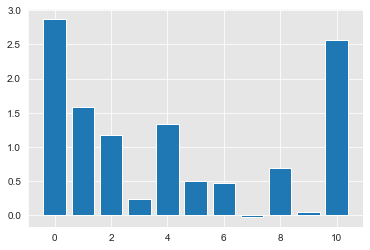

In [113]:
importance = log3_best['log'].coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [114]:
pd.DataFrame.from_dict(dict(zip(threats_train.columns,importance)), orient='index').sort_values(by=0, ascending=False)

,0
agriculture_threat,2.868758
invasive_threat,2.568568
biological_threat,1.581809
geological_threat,1.338888
climate_change_threat,1.169018
res_comm_dev_threat,0.680893
human_intrusions_threat,0.498886
natural_systems_threat,0.463457
energy_mining_threat,0.230050
transportation_threat,0.046625
